In [1]:
import pandas as pd
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.utils.data as Data

In [2]:
class Preprocessing:

    def drop_na(df, params):
        params.append("cleavage_freq")
        for col in params:
            df = df[df[col].notna()]
        params.remove("cleavage_freq")
        return df

    def select(df, params):
        df = df[params]
        df[params] = df[params].convert_dtypes()
        return df
    
    def symbol_mapping(sym):
        mapping = {'+': 1.00, '-': 0.00}
        return mapping.get(sym)

    def encode_strand(df):
        df["target_strand"] = [
            Preprocessing.symbol_mapping(sym)
            for sym in df["target_strand"]
        ]
        df["grna_target_strand"] = [
            Preprocessing.symbol_mapping(sym)
            for sym in df["grna_target_strand"]
        ]
        return df

    def study_mapping(name):
        mapping = {
            'Tsai_circle': 0.00/16.00,
            'Finkelstein': 1.00/16.00,
            'Tsai': 2.00/16.00,
            'Cameron': 3.00/16.00,
            'Kleinstiver': 4.00/16.00,
            'Slaymaker': 5.00/16.00,
            'Kim16': 6.00/16.00,
            'Ran': 7.00/16.00,
            'Anderson': 8.00/16.00,
            'KimChromatin': 9.00/16.00,
            'Chen17': 10.00/16.00,
            'Listgarten': 11.00/16.00,
            'Cho': 12.00/16.00,
            'Kim': 13.00/16.00,
            'Fu': 14.00/16.00,
            'Frock': 15.00/16.00,
            'Wang': 16.00/16.00
        }
        return mapping.get(name)

    def encode_study(df):
        df["study_name"] = [
            Preprocessing.study_mapping(name)
            for name in df["study_name"]
        ]
        return df

    def remove_dash(df):
        for col in df.select_dtypes(exclude = ["number"]).columns:
            df[col] = [
                seq.replace("-", "")
                for seq in df[col]
            ]
        return df
    
    def pad(df):
        for col in df.select_dtypes(exclude = ["number"]).columns:
            df[col] = df[col].str.pad(width = 50, side = "right", fillchar = "X")
        return df

    def encode_nt_onehot(nt:str) -> int:
        assert len(nt) == 1
        encoding_dict = {
            'X': [0, 0, 0, 0],
            'A': [1, 0, 0, 0],
            'T': [0, 1, 0, 0],
            'G': [0, 0, 1, 0],
            'C': [0, 0, 0, 1]
        }
        return encoding_dict.get(nt.upper())

    def encode_seq_onehot(seq:str):
        encoding = [
            Preprocessing.encode_nt_onehot(nt)
            for nt in seq
        ]
        encoding = np.asarray(encoding).flatten()
        return np.array(encoding)

    def encode_col_onehot(df, col):
        encoded = [
            Preprocessing.encode_seq_onehot(seq)
            for seq in df[col]
        ]
        return encoded
    
    def fold_2(df):
        target_seq = Preprocessing.encode_col_onehot(df, "target_sequence")
        grna_target_seq = Preprocessing.encode_col_onehot(df, "grna_target_sequence")

        target_seq = np.asarray(target_seq, dtype = np.float32)
        grna_target_seq = np.asarray(grna_target_seq, dtype = np.float32)
        seqs = np.concatenate((target_seq, grna_target_seq), axis = 1)
        target_strand = np.asarray(df["target_strand"], dtype = np.float32)
        grna_target_strand = np.asarray(df["grna_target_strand"], dtype = np.float32)
        strands = zip(target_strand, grna_target_strand)
        strands = tuple(strands)
        strands = np.asarray(strands, dtype = np.float32)
        e1 = df["energy_1"]
        e2 = df["energy_2"]
        e3 = df["energy_3"]
        e4 = df["energy_4"]
        e5 = df["energy_5"]

        energies = zip(e1, e2, e3, e4, e5)
        energies = tuple(energies)
        energies = np.asarray(energies, dtype = np.float32)

        study_name = df["study_name"]
        delivery_mode = df["delivery_mode"]
        whole_genome = df["whole_genome"]

        study_details = zip(study_name, delivery_mode, whole_genome)
        study_details = tuple(study_details)
        study_details = np.asarray(study_details, dtype = np.float32)

        all_data = np.concatenate((strands, seqs, energies, study_details), axis = 1)

        X = torch.from_numpy(all_data)
        return X
    
    def get_X_2(df, params):
        df = Preprocessing.select(df, params)
        df = Preprocessing.encode_strand(df)
        df = Preprocessing.encode_study(df)
        df = Preprocessing.remove_dash(df)
        df = Preprocessing.pad(df)
        X = Preprocessing.fold_2(df)
        return X
    
    def get_y(df):
        df = df["cleavage_freq"]
        y = np.array(df).reshape(df.shape[0], 1).astype(np.float32)
        y = torch.tensor(y)
        return y

    


In [3]:
class LinearRegressor2:
    
    def __init__(self, model_file_path):
        self.model_file_path = model_file_path
        self.params = ["target_strand", 
          "grna_target_strand",
          "target_sequence", 
          "grna_target_sequence",
          "energy_1",
          "energy_2",
          "energy_3",
          "energy_4",
          "energy_5",
          "study_name",
          "whole_genome",
          "delivery_mode"
         ]
    
    def train(self, df_train):
        df_train = Preprocessing.drop_na(df_train, self.params)
        X = Preprocessing.get_X_2(df_train, self.params)
        y = Preprocessing.get_y(df_train)

        input_dim = X.shape[1]
        X = Variable(X)
        y = Variable(y)

        model = nn.Linear(input_dim, 1)
        loss_func = nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr = 0.000001)
        BATCH_SIZE = 1
        EPOCH = 1

        torch_dataset = Data.TensorDataset(X, y)
        loader = Data.DataLoader(
            dataset = torch_dataset,
            batch_size = BATCH_SIZE,
            shuffle = True,
            num_workers = 2
        )
        for epoch in range(EPOCH):
            for step, (batch_x, batch_y) in enumerate(loader):
                prediction = model(batch_x)
                print(prediction)
                loss = loss_func(prediction, batch_y)
                loss.backward()
                optimizer.step()

        with open(self.model_file_path, 'wb') as model_file:
            pickle.dump(model, model_file)

    def predict(self, df_test):
        with open(self.model_file_path, 'rb') as model_file:
            model: model = pickle.load(model_file)

        df_test = Preprocessing.drop_na(df_test, self.params)
        X = Preprocessing.get_X_2(df_test, self.params)
        y_predictions = model(X)
        y_actuals = Preprocessing.get_y(df_test)
        return y_predictions, y_actuals

    def train_hyperparams(self, df_train, batch, epoch, learning_rate):
        df_train = Preprocessing.drop_na(df_train, self.params)
        X = Preprocessing.get_X_2(df_train, self.params)
        y = Preprocessing.get_y(df_train)

        input_dim = X.shape[1]
        X = Variable(X)
        y = Variable(y)
        model = nn.Linear(input_dim, 1)
        loss_func = nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
        BATCH_SIZE = int(batch)
        EPOCH = int(epoch)
        torch_dataset = Data.TensorDataset(X, y)
        loader = Data.DataLoader(
            dataset = torch_dataset,
            batch_size = BATCH_SIZE,
            shuffle = True,
            num_workers = 2
        )
        for epoch in range(EPOCH):
            for step, (batch_x, batch_y) in enumerate(loader):
                prediction = model(batch_x)
                loss = loss_func(prediction, batch_y)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

        with open(self.model_file_path, 'wb') as model_file:
            pickle.dump(model, model_file)

In [4]:
df_train = pd.read_csv("../data/train.csv")
model_file_path = "./src/model2.pkl"
LinearRegressor2(model_file_path = model_file_path).train(df_train)

/home/megan/.local/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/home/megan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/megan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

tensor([[-0.1058]], grad_fn=<AddmmBackward>)
tensor([[0.1570]], grad_fn=<AddmmBackward>)
tensor([[-0.1966]], grad_fn=<AddmmBackward>)
tensor([[0.0015]], grad_fn=<AddmmBackward>)
tensor([[0.3545]], grad_fn=<AddmmBackward>)
tensor([[0.1458]], grad_fn=<AddmmBackward>)
tensor([[0.0855]], grad_fn=<AddmmBackward>)
tensor([[0.3581]], grad_fn=<AddmmBackward>)
tensor([[0.1574]], grad_fn=<AddmmBackward>)
tensor([[0.1077]], grad_fn=<AddmmBackward>)
tensor([[-0.0708]], grad_fn=<AddmmBackward>)
tensor([[-0.1341]], grad_fn=<AddmmBackward>)
tensor([[-0.0243]], grad_fn=<AddmmBackward>)
tensor([[-0.0467]], grad_fn=<AddmmBackward>)
tensor([[-0.3305]], grad_fn=<AddmmBackward>)
tensor([[0.0625]], grad_fn=<AddmmBackward>)
tensor([[0.3089]], grad_fn=<AddmmBackward>)
tensor([[0.3801]], grad_fn=<AddmmBackward>)
tensor([[0.1258]], grad_fn=<AddmmBackward>)
tensor([[0.0162]], grad_fn=<AddmmBackward>)
tensor([[0.1888]], grad_fn=<AddmmBackward>)
tensor([[0.5558]], grad_fn=<AddmmBackward>)
tensor([[0.3365]], grad_f

tensor([[0.3472]], grad_fn=<AddmmBackward>)
tensor([[-0.1146]], grad_fn=<AddmmBackward>)
tensor([[-0.7945]], grad_fn=<AddmmBackward>)
tensor([[0.7337]], grad_fn=<AddmmBackward>)
tensor([[-0.8231]], grad_fn=<AddmmBackward>)
tensor([[0.0328]], grad_fn=<AddmmBackward>)
tensor([[0.0281]], grad_fn=<AddmmBackward>)
tensor([[-0.4801]], grad_fn=<AddmmBackward>)
tensor([[0.2849]], grad_fn=<AddmmBackward>)
tensor([[-0.1227]], grad_fn=<AddmmBackward>)
tensor([[-0.0538]], grad_fn=<AddmmBackward>)
tensor([[-0.5737]], grad_fn=<AddmmBackward>)
tensor([[-0.6322]], grad_fn=<AddmmBackward>)
tensor([[0.1181]], grad_fn=<AddmmBackward>)
tensor([[-0.5390]], grad_fn=<AddmmBackward>)
tensor([[-0.2628]], grad_fn=<AddmmBackward>)
tensor([[-0.0991]], grad_fn=<AddmmBackward>)
tensor([[-0.3233]], grad_fn=<AddmmBackward>)
tensor([[-0.2105]], grad_fn=<AddmmBackward>)
tensor([[-0.2977]], grad_fn=<AddmmBackward>)
tensor([[-0.0364]], grad_fn=<AddmmBackward>)
tensor([[-0.0471]], grad_fn=<AddmmBackward>)
tensor([[-0.0273

tensor([[0.9984]], grad_fn=<AddmmBackward>)
tensor([[0.5167]], grad_fn=<AddmmBackward>)
tensor([[0.2251]], grad_fn=<AddmmBackward>)
tensor([[0.4312]], grad_fn=<AddmmBackward>)
tensor([[-0.5092]], grad_fn=<AddmmBackward>)
tensor([[-0.1091]], grad_fn=<AddmmBackward>)
tensor([[0.5197]], grad_fn=<AddmmBackward>)
tensor([[-1.0384]], grad_fn=<AddmmBackward>)
tensor([[-0.3749]], grad_fn=<AddmmBackward>)
tensor([[0.4360]], grad_fn=<AddmmBackward>)
tensor([[-0.0482]], grad_fn=<AddmmBackward>)
tensor([[-1.0503]], grad_fn=<AddmmBackward>)
tensor([[-0.6870]], grad_fn=<AddmmBackward>)
tensor([[0.5971]], grad_fn=<AddmmBackward>)
tensor([[0.4125]], grad_fn=<AddmmBackward>)
tensor([[0.0720]], grad_fn=<AddmmBackward>)
tensor([[0.4568]], grad_fn=<AddmmBackward>)
tensor([[0.3487]], grad_fn=<AddmmBackward>)
tensor([[0.5795]], grad_fn=<AddmmBackward>)
tensor([[1.4264]], grad_fn=<AddmmBackward>)
tensor([[-0.3935]], grad_fn=<AddmmBackward>)
tensor([[1.2019]], grad_fn=<AddmmBackward>)
tensor([[0.6024]], grad_

tensor([[1.2158]], grad_fn=<AddmmBackward>)
tensor([[0.3653]], grad_fn=<AddmmBackward>)
tensor([[-0.0778]], grad_fn=<AddmmBackward>)
tensor([[-0.0280]], grad_fn=<AddmmBackward>)
tensor([[-0.1318]], grad_fn=<AddmmBackward>)
tensor([[0.0928]], grad_fn=<AddmmBackward>)
tensor([[0.0187]], grad_fn=<AddmmBackward>)
tensor([[0.9469]], grad_fn=<AddmmBackward>)
tensor([[0.0843]], grad_fn=<AddmmBackward>)
tensor([[-0.1415]], grad_fn=<AddmmBackward>)
tensor([[0.0837]], grad_fn=<AddmmBackward>)
tensor([[0.0740]], grad_fn=<AddmmBackward>)
tensor([[-0.0003]], grad_fn=<AddmmBackward>)
tensor([[0.5984]], grad_fn=<AddmmBackward>)
tensor([[0.0601]], grad_fn=<AddmmBackward>)
tensor([[0.3063]], grad_fn=<AddmmBackward>)
tensor([[0.1043]], grad_fn=<AddmmBackward>)
tensor([[0.1799]], grad_fn=<AddmmBackward>)
tensor([[0.0559]], grad_fn=<AddmmBackward>)
tensor([[0.0583]], grad_fn=<AddmmBackward>)
tensor([[0.0848]], grad_fn=<AddmmBackward>)
tensor([[0.0815]], grad_fn=<AddmmBackward>)
tensor([[-0.1724]], grad_fn

tensor([[0.2149]], grad_fn=<AddmmBackward>)
tensor([[-0.4148]], grad_fn=<AddmmBackward>)
tensor([[-0.7614]], grad_fn=<AddmmBackward>)
tensor([[0.8204]], grad_fn=<AddmmBackward>)
tensor([[-0.7741]], grad_fn=<AddmmBackward>)
tensor([[-1.3674]], grad_fn=<AddmmBackward>)
tensor([[-1.1709]], grad_fn=<AddmmBackward>)
tensor([[-0.3718]], grad_fn=<AddmmBackward>)
tensor([[-0.7938]], grad_fn=<AddmmBackward>)
tensor([[0.6930]], grad_fn=<AddmmBackward>)
tensor([[-0.4835]], grad_fn=<AddmmBackward>)
tensor([[1.7224]], grad_fn=<AddmmBackward>)
tensor([[-1.2556]], grad_fn=<AddmmBackward>)
tensor([[0.7027]], grad_fn=<AddmmBackward>)
tensor([[-1.2668]], grad_fn=<AddmmBackward>)
tensor([[-2.0497]], grad_fn=<AddmmBackward>)
tensor([[-1.9409]], grad_fn=<AddmmBackward>)
tensor([[-2.5431]], grad_fn=<AddmmBackward>)
tensor([[-0.2367]], grad_fn=<AddmmBackward>)
tensor([[-2.3539]], grad_fn=<AddmmBackward>)
tensor([[-1.1009]], grad_fn=<AddmmBackward>)
tensor([[2.2200]], grad_fn=<AddmmBackward>)
tensor([[-2.0197

tensor([[-5.2255]], grad_fn=<AddmmBackward>)
tensor([[2.0978]], grad_fn=<AddmmBackward>)
tensor([[1.6763]], grad_fn=<AddmmBackward>)
tensor([[-1.7579]], grad_fn=<AddmmBackward>)
tensor([[0.5028]], grad_fn=<AddmmBackward>)
tensor([[-2.7677]], grad_fn=<AddmmBackward>)
tensor([[-5.5713]], grad_fn=<AddmmBackward>)
tensor([[-4.6595]], grad_fn=<AddmmBackward>)
tensor([[1.1872]], grad_fn=<AddmmBackward>)
tensor([[-2.3149]], grad_fn=<AddmmBackward>)
tensor([[1.1593]], grad_fn=<AddmmBackward>)
tensor([[1.2584]], grad_fn=<AddmmBackward>)
tensor([[-0.2541]], grad_fn=<AddmmBackward>)
tensor([[1.3363]], grad_fn=<AddmmBackward>)
tensor([[-0.0325]], grad_fn=<AddmmBackward>)
tensor([[0.8221]], grad_fn=<AddmmBackward>)
tensor([[1.4478]], grad_fn=<AddmmBackward>)
tensor([[0.1295]], grad_fn=<AddmmBackward>)
tensor([[-0.6435]], grad_fn=<AddmmBackward>)
tensor([[0.0584]], grad_fn=<AddmmBackward>)
tensor([[0.7676]], grad_fn=<AddmmBackward>)
tensor([[0.3127]], grad_fn=<AddmmBackward>)
tensor([[0.2274]], grad

tensor([[0.5153]], grad_fn=<AddmmBackward>)
tensor([[0.3546]], grad_fn=<AddmmBackward>)
tensor([[0.1774]], grad_fn=<AddmmBackward>)
tensor([[-0.7003]], grad_fn=<AddmmBackward>)
tensor([[-0.6147]], grad_fn=<AddmmBackward>)
tensor([[0.0053]], grad_fn=<AddmmBackward>)
tensor([[-0.8287]], grad_fn=<AddmmBackward>)
tensor([[-0.1801]], grad_fn=<AddmmBackward>)
tensor([[-0.2432]], grad_fn=<AddmmBackward>)
tensor([[-0.3417]], grad_fn=<AddmmBackward>)
tensor([[0.6870]], grad_fn=<AddmmBackward>)
tensor([[0.1750]], grad_fn=<AddmmBackward>)
tensor([[0.0279]], grad_fn=<AddmmBackward>)
tensor([[1.1066]], grad_fn=<AddmmBackward>)
tensor([[-0.7814]], grad_fn=<AddmmBackward>)
tensor([[-0.2168]], grad_fn=<AddmmBackward>)
tensor([[0.8337]], grad_fn=<AddmmBackward>)
tensor([[0.3569]], grad_fn=<AddmmBackward>)
tensor([[1.1575]], grad_fn=<AddmmBackward>)
tensor([[1.6361]], grad_fn=<AddmmBackward>)
tensor([[-0.2587]], grad_fn=<AddmmBackward>)
tensor([[0.4214]], grad_fn=<AddmmBackward>)
tensor([[0.5147]], grad

tensor([[-0.3262]], grad_fn=<AddmmBackward>)
tensor([[0.5819]], grad_fn=<AddmmBackward>)
tensor([[0.4777]], grad_fn=<AddmmBackward>)
tensor([[-0.8926]], grad_fn=<AddmmBackward>)
tensor([[1.3554]], grad_fn=<AddmmBackward>)
tensor([[-0.6146]], grad_fn=<AddmmBackward>)
tensor([[-0.2892]], grad_fn=<AddmmBackward>)
tensor([[2.5892]], grad_fn=<AddmmBackward>)
tensor([[3.0227]], grad_fn=<AddmmBackward>)
tensor([[-0.0668]], grad_fn=<AddmmBackward>)
tensor([[4.9187]], grad_fn=<AddmmBackward>)
tensor([[1.3435]], grad_fn=<AddmmBackward>)
tensor([[-2.4059]], grad_fn=<AddmmBackward>)
tensor([[0.9113]], grad_fn=<AddmmBackward>)
tensor([[-1.8244]], grad_fn=<AddmmBackward>)
tensor([[-0.2877]], grad_fn=<AddmmBackward>)
tensor([[1.7807]], grad_fn=<AddmmBackward>)
tensor([[-2.5130]], grad_fn=<AddmmBackward>)
tensor([[0.3626]], grad_fn=<AddmmBackward>)
tensor([[-3.5798]], grad_fn=<AddmmBackward>)
tensor([[2.9431]], grad_fn=<AddmmBackward>)
tensor([[-0.9837]], grad_fn=<AddmmBackward>)
tensor([[3.0249]], gr

tensor([[-2.2323]], grad_fn=<AddmmBackward>)
tensor([[0.1443]], grad_fn=<AddmmBackward>)
tensor([[-0.7812]], grad_fn=<AddmmBackward>)
tensor([[2.1937]], grad_fn=<AddmmBackward>)
tensor([[0.0849]], grad_fn=<AddmmBackward>)
tensor([[-3.8797]], grad_fn=<AddmmBackward>)
tensor([[0.4691]], grad_fn=<AddmmBackward>)
tensor([[0.0890]], grad_fn=<AddmmBackward>)
tensor([[0.1867]], grad_fn=<AddmmBackward>)
tensor([[-2.2724]], grad_fn=<AddmmBackward>)
tensor([[-2.0246]], grad_fn=<AddmmBackward>)
tensor([[0.0643]], grad_fn=<AddmmBackward>)
tensor([[0.2366]], grad_fn=<AddmmBackward>)
tensor([[-1.7395]], grad_fn=<AddmmBackward>)
tensor([[-2.8806]], grad_fn=<AddmmBackward>)
tensor([[-0.1289]], grad_fn=<AddmmBackward>)
tensor([[-2.1082]], grad_fn=<AddmmBackward>)
tensor([[-0.4655]], grad_fn=<AddmmBackward>)
tensor([[-2.2254]], grad_fn=<AddmmBackward>)
tensor([[0.0365]], grad_fn=<AddmmBackward>)
tensor([[-2.8432]], grad_fn=<AddmmBackward>)
tensor([[1.6089]], grad_fn=<AddmmBackward>)
tensor([[-0.0749]], 

tensor([[0.2558]], grad_fn=<AddmmBackward>)
tensor([[-0.8807]], grad_fn=<AddmmBackward>)
tensor([[0.5547]], grad_fn=<AddmmBackward>)
tensor([[-0.6414]], grad_fn=<AddmmBackward>)
tensor([[-0.9297]], grad_fn=<AddmmBackward>)
tensor([[0.4509]], grad_fn=<AddmmBackward>)
tensor([[-0.5580]], grad_fn=<AddmmBackward>)
tensor([[-0.6122]], grad_fn=<AddmmBackward>)
tensor([[-0.9304]], grad_fn=<AddmmBackward>)
tensor([[-0.8859]], grad_fn=<AddmmBackward>)
tensor([[-0.2901]], grad_fn=<AddmmBackward>)
tensor([[-0.3635]], grad_fn=<AddmmBackward>)
tensor([[-0.4856]], grad_fn=<AddmmBackward>)
tensor([[-0.1770]], grad_fn=<AddmmBackward>)
tensor([[-0.1611]], grad_fn=<AddmmBackward>)
tensor([[-1.0611]], grad_fn=<AddmmBackward>)
tensor([[0.2156]], grad_fn=<AddmmBackward>)
tensor([[-0.1237]], grad_fn=<AddmmBackward>)
tensor([[0.2809]], grad_fn=<AddmmBackward>)
tensor([[0.2789]], grad_fn=<AddmmBackward>)
tensor([[0.6919]], grad_fn=<AddmmBackward>)
tensor([[-0.5483]], grad_fn=<AddmmBackward>)
tensor([[0.6804]]

tensor([[-0.4304]], grad_fn=<AddmmBackward>)
tensor([[-0.9588]], grad_fn=<AddmmBackward>)
tensor([[-0.1810]], grad_fn=<AddmmBackward>)
tensor([[0.4247]], grad_fn=<AddmmBackward>)
tensor([[2.6971]], grad_fn=<AddmmBackward>)
tensor([[0.5791]], grad_fn=<AddmmBackward>)
tensor([[0.4673]], grad_fn=<AddmmBackward>)
tensor([[5.3598]], grad_fn=<AddmmBackward>)
tensor([[2.1026]], grad_fn=<AddmmBackward>)
tensor([[0.8310]], grad_fn=<AddmmBackward>)
tensor([[0.7279]], grad_fn=<AddmmBackward>)
tensor([[-0.1288]], grad_fn=<AddmmBackward>)
tensor([[4.3115]], grad_fn=<AddmmBackward>)
tensor([[-0.4763]], grad_fn=<AddmmBackward>)
tensor([[0.0563]], grad_fn=<AddmmBackward>)
tensor([[-4.6343]], grad_fn=<AddmmBackward>)
tensor([[-2.3570]], grad_fn=<AddmmBackward>)
tensor([[1.3415]], grad_fn=<AddmmBackward>)
tensor([[0.3742]], grad_fn=<AddmmBackward>)
tensor([[0.6080]], grad_fn=<AddmmBackward>)
tensor([[0.2890]], grad_fn=<AddmmBackward>)
tensor([[0.4491]], grad_fn=<AddmmBackward>)
tensor([[0.2282]], grad_f

tensor([[-1.4655]], grad_fn=<AddmmBackward>)
tensor([[2.4555]], grad_fn=<AddmmBackward>)
tensor([[2.5101]], grad_fn=<AddmmBackward>)
tensor([[-0.8114]], grad_fn=<AddmmBackward>)
tensor([[3.4714]], grad_fn=<AddmmBackward>)
tensor([[-1.6880]], grad_fn=<AddmmBackward>)
tensor([[-1.2746]], grad_fn=<AddmmBackward>)
tensor([[4.1639]], grad_fn=<AddmmBackward>)
tensor([[-0.7952]], grad_fn=<AddmmBackward>)
tensor([[3.4040]], grad_fn=<AddmmBackward>)
tensor([[-0.7833]], grad_fn=<AddmmBackward>)
tensor([[3.0653]], grad_fn=<AddmmBackward>)
tensor([[3.4495]], grad_fn=<AddmmBackward>)
tensor([[-1.9467]], grad_fn=<AddmmBackward>)
tensor([[0.4107]], grad_fn=<AddmmBackward>)
tensor([[3.0906]], grad_fn=<AddmmBackward>)
tensor([[-0.9693]], grad_fn=<AddmmBackward>)
tensor([[-1.7891]], grad_fn=<AddmmBackward>)
tensor([[-0.7575]], grad_fn=<AddmmBackward>)
tensor([[-2.6600]], grad_fn=<AddmmBackward>)
tensor([[-1.9519]], grad_fn=<AddmmBackward>)
tensor([[-1.7818]], grad_fn=<AddmmBackward>)
tensor([[3.3564]], 

tensor([[-0.2749]], grad_fn=<AddmmBackward>)
tensor([[1.5177]], grad_fn=<AddmmBackward>)
tensor([[0.2770]], grad_fn=<AddmmBackward>)
tensor([[-0.1314]], grad_fn=<AddmmBackward>)
tensor([[-0.9195]], grad_fn=<AddmmBackward>)
tensor([[1.3174]], grad_fn=<AddmmBackward>)
tensor([[0.7344]], grad_fn=<AddmmBackward>)
tensor([[-2.5171]], grad_fn=<AddmmBackward>)
tensor([[-5.6871]], grad_fn=<AddmmBackward>)
tensor([[-5.2081]], grad_fn=<AddmmBackward>)
tensor([[0.7961]], grad_fn=<AddmmBackward>)
tensor([[-3.6269]], grad_fn=<AddmmBackward>)
tensor([[-0.7245]], grad_fn=<AddmmBackward>)
tensor([[-6.6076]], grad_fn=<AddmmBackward>)
tensor([[2.0852]], grad_fn=<AddmmBackward>)
tensor([[2.1278]], grad_fn=<AddmmBackward>)
tensor([[-5.3040]], grad_fn=<AddmmBackward>)
tensor([[-5.4735]], grad_fn=<AddmmBackward>)
tensor([[2.1715]], grad_fn=<AddmmBackward>)
tensor([[-6.5578]], grad_fn=<AddmmBackward>)
tensor([[-4.5181]], grad_fn=<AddmmBackward>)
tensor([[-3.2112]], grad_fn=<AddmmBackward>)
tensor([[-0.1592]]

tensor([[-2.6862]], grad_fn=<AddmmBackward>)
tensor([[1.1440]], grad_fn=<AddmmBackward>)
tensor([[2.0218]], grad_fn=<AddmmBackward>)
tensor([[-2.6969]], grad_fn=<AddmmBackward>)
tensor([[0.9001]], grad_fn=<AddmmBackward>)
tensor([[-1.8195]], grad_fn=<AddmmBackward>)
tensor([[-2.2287]], grad_fn=<AddmmBackward>)
tensor([[-2.7176]], grad_fn=<AddmmBackward>)
tensor([[-1.0308]], grad_fn=<AddmmBackward>)
tensor([[0.9201]], grad_fn=<AddmmBackward>)
tensor([[-1.7176]], grad_fn=<AddmmBackward>)
tensor([[-1.4564]], grad_fn=<AddmmBackward>)
tensor([[-1.4637]], grad_fn=<AddmmBackward>)
tensor([[-2.3354]], grad_fn=<AddmmBackward>)
tensor([[-1.0005]], grad_fn=<AddmmBackward>)
tensor([[-2.1160]], grad_fn=<AddmmBackward>)
tensor([[-1.4623]], grad_fn=<AddmmBackward>)
tensor([[0.1177]], grad_fn=<AddmmBackward>)
tensor([[0.2198]], grad_fn=<AddmmBackward>)
tensor([[-1.9680]], grad_fn=<AddmmBackward>)
tensor([[0.6188]], grad_fn=<AddmmBackward>)
tensor([[-0.2358]], grad_fn=<AddmmBackward>)
tensor([[-1.4727]

tensor([[1.2639]], grad_fn=<AddmmBackward>)
tensor([[1.0103]], grad_fn=<AddmmBackward>)
tensor([[1.1877]], grad_fn=<AddmmBackward>)
tensor([[0.5887]], grad_fn=<AddmmBackward>)
tensor([[1.6291]], grad_fn=<AddmmBackward>)
tensor([[0.9023]], grad_fn=<AddmmBackward>)
tensor([[2.4718]], grad_fn=<AddmmBackward>)
tensor([[2.2027]], grad_fn=<AddmmBackward>)
tensor([[1.1143]], grad_fn=<AddmmBackward>)
tensor([[0.9872]], grad_fn=<AddmmBackward>)
tensor([[0.5837]], grad_fn=<AddmmBackward>)
tensor([[0.6194]], grad_fn=<AddmmBackward>)
tensor([[-2.1323]], grad_fn=<AddmmBackward>)
tensor([[0.7229]], grad_fn=<AddmmBackward>)
tensor([[1.9923]], grad_fn=<AddmmBackward>)
tensor([[-2.9257]], grad_fn=<AddmmBackward>)
tensor([[1.5147]], grad_fn=<AddmmBackward>)
tensor([[1.5928]], grad_fn=<AddmmBackward>)
tensor([[2.9479]], grad_fn=<AddmmBackward>)
tensor([[1.6760]], grad_fn=<AddmmBackward>)
tensor([[2.9128]], grad_fn=<AddmmBackward>)
tensor([[1.9472]], grad_fn=<AddmmBackward>)
tensor([[1.9716]], grad_fn=<Ad

tensor([[2.0781]], grad_fn=<AddmmBackward>)
tensor([[-0.0708]], grad_fn=<AddmmBackward>)
tensor([[-1.3174]], grad_fn=<AddmmBackward>)
tensor([[0.8764]], grad_fn=<AddmmBackward>)
tensor([[0.4789]], grad_fn=<AddmmBackward>)
tensor([[0.7461]], grad_fn=<AddmmBackward>)
tensor([[-1.4017]], grad_fn=<AddmmBackward>)
tensor([[-1.2352]], grad_fn=<AddmmBackward>)
tensor([[2.5433]], grad_fn=<AddmmBackward>)
tensor([[-0.1401]], grad_fn=<AddmmBackward>)
tensor([[0.4822]], grad_fn=<AddmmBackward>)
tensor([[0.6632]], grad_fn=<AddmmBackward>)
tensor([[1.7745]], grad_fn=<AddmmBackward>)
tensor([[0.9006]], grad_fn=<AddmmBackward>)
tensor([[1.6852]], grad_fn=<AddmmBackward>)
tensor([[1.6816]], grad_fn=<AddmmBackward>)
tensor([[1.4651]], grad_fn=<AddmmBackward>)
tensor([[-0.6229]], grad_fn=<AddmmBackward>)
tensor([[0.7364]], grad_fn=<AddmmBackward>)
tensor([[-1.6571]], grad_fn=<AddmmBackward>)
tensor([[-0.3594]], grad_fn=<AddmmBackward>)
tensor([[-0.4471]], grad_fn=<AddmmBackward>)
tensor([[0.1093]], grad

tensor([[2.2095]], grad_fn=<AddmmBackward>)
tensor([[-1.1078]], grad_fn=<AddmmBackward>)
tensor([[-0.8353]], grad_fn=<AddmmBackward>)
tensor([[1.4208]], grad_fn=<AddmmBackward>)
tensor([[1.0055]], grad_fn=<AddmmBackward>)
tensor([[-0.0513]], grad_fn=<AddmmBackward>)
tensor([[0.6125]], grad_fn=<AddmmBackward>)
tensor([[-0.7021]], grad_fn=<AddmmBackward>)
tensor([[-0.2924]], grad_fn=<AddmmBackward>)
tensor([[0.3568]], grad_fn=<AddmmBackward>)
tensor([[0.5553]], grad_fn=<AddmmBackward>)
tensor([[2.0738]], grad_fn=<AddmmBackward>)
tensor([[-0.5349]], grad_fn=<AddmmBackward>)
tensor([[0.1860]], grad_fn=<AddmmBackward>)
tensor([[-0.1936]], grad_fn=<AddmmBackward>)
tensor([[-0.2037]], grad_fn=<AddmmBackward>)
tensor([[-0.5056]], grad_fn=<AddmmBackward>)
tensor([[-0.4505]], grad_fn=<AddmmBackward>)
tensor([[-0.0930]], grad_fn=<AddmmBackward>)
tensor([[-1.7245]], grad_fn=<AddmmBackward>)
tensor([[-0.7980]], grad_fn=<AddmmBackward>)
tensor([[-1.7874]], grad_fn=<AddmmBackward>)
tensor([[0.5392]],

tensor([[-5.8258]], grad_fn=<AddmmBackward>)
tensor([[-0.1904]], grad_fn=<AddmmBackward>)
tensor([[-2.1000]], grad_fn=<AddmmBackward>)
tensor([[-0.2726]], grad_fn=<AddmmBackward>)
tensor([[2.9104]], grad_fn=<AddmmBackward>)
tensor([[-8.3395]], grad_fn=<AddmmBackward>)
tensor([[-1.3683]], grad_fn=<AddmmBackward>)
tensor([[0.8771]], grad_fn=<AddmmBackward>)
tensor([[-5.0571]], grad_fn=<AddmmBackward>)
tensor([[1.6677]], grad_fn=<AddmmBackward>)
tensor([[-6.5890]], grad_fn=<AddmmBackward>)
tensor([[-0.0689]], grad_fn=<AddmmBackward>)
tensor([[-8.1170]], grad_fn=<AddmmBackward>)
tensor([[1.7220]], grad_fn=<AddmmBackward>)
tensor([[0.8618]], grad_fn=<AddmmBackward>)
tensor([[-6.7654]], grad_fn=<AddmmBackward>)
tensor([[2.0952]], grad_fn=<AddmmBackward>)
tensor([[-3.2066]], grad_fn=<AddmmBackward>)
tensor([[3.0941]], grad_fn=<AddmmBackward>)
tensor([[0.1143]], grad_fn=<AddmmBackward>)
tensor([[-5.1759]], grad_fn=<AddmmBackward>)
tensor([[-5.0831]], grad_fn=<AddmmBackward>)
tensor([[4.4089]],

tensor([[6.5595]], grad_fn=<AddmmBackward>)
tensor([[6.5905]], grad_fn=<AddmmBackward>)
tensor([[-8.3988]], grad_fn=<AddmmBackward>)
tensor([[-2.3559]], grad_fn=<AddmmBackward>)
tensor([[5.0701]], grad_fn=<AddmmBackward>)
tensor([[3.9845]], grad_fn=<AddmmBackward>)
tensor([[6.5020]], grad_fn=<AddmmBackward>)
tensor([[2.1533]], grad_fn=<AddmmBackward>)
tensor([[4.9761]], grad_fn=<AddmmBackward>)
tensor([[-1.3644]], grad_fn=<AddmmBackward>)
tensor([[4.5205]], grad_fn=<AddmmBackward>)
tensor([[4.9419]], grad_fn=<AddmmBackward>)
tensor([[3.3126]], grad_fn=<AddmmBackward>)
tensor([[3.2950]], grad_fn=<AddmmBackward>)
tensor([[0.4246]], grad_fn=<AddmmBackward>)
tensor([[-5.0865]], grad_fn=<AddmmBackward>)
tensor([[5.2342]], grad_fn=<AddmmBackward>)
tensor([[-1.3906]], grad_fn=<AddmmBackward>)
tensor([[0.2054]], grad_fn=<AddmmBackward>)
tensor([[-2.9371]], grad_fn=<AddmmBackward>)
tensor([[2.9770]], grad_fn=<AddmmBackward>)
tensor([[4.2217]], grad_fn=<AddmmBackward>)
tensor([[-4.8033]], grad_f

tensor([[-0.7522]], grad_fn=<AddmmBackward>)
tensor([[-1.9156]], grad_fn=<AddmmBackward>)
tensor([[-4.3895]], grad_fn=<AddmmBackward>)
tensor([[0.1496]], grad_fn=<AddmmBackward>)
tensor([[-4.6842]], grad_fn=<AddmmBackward>)
tensor([[-0.5444]], grad_fn=<AddmmBackward>)
tensor([[-3.4851]], grad_fn=<AddmmBackward>)
tensor([[-4.4533]], grad_fn=<AddmmBackward>)
tensor([[-1.1745]], grad_fn=<AddmmBackward>)
tensor([[-0.2212]], grad_fn=<AddmmBackward>)
tensor([[-6.0243]], grad_fn=<AddmmBackward>)
tensor([[-4.4343]], grad_fn=<AddmmBackward>)
tensor([[-0.2956]], grad_fn=<AddmmBackward>)
tensor([[-8.3953]], grad_fn=<AddmmBackward>)
tensor([[-5.8795]], grad_fn=<AddmmBackward>)
tensor([[-3.1351]], grad_fn=<AddmmBackward>)
tensor([[-5.1370]], grad_fn=<AddmmBackward>)
tensor([[-0.0491]], grad_fn=<AddmmBackward>)
tensor([[0.4405]], grad_fn=<AddmmBackward>)
tensor([[-9.6369]], grad_fn=<AddmmBackward>)
tensor([[0.3367]], grad_fn=<AddmmBackward>)
tensor([[-1.6777]], grad_fn=<AddmmBackward>)
tensor([[-0.3

tensor([[-3.9300]], grad_fn=<AddmmBackward>)
tensor([[-5.5033]], grad_fn=<AddmmBackward>)
tensor([[-2.6591]], grad_fn=<AddmmBackward>)
tensor([[-6.0186]], grad_fn=<AddmmBackward>)
tensor([[4.6912]], grad_fn=<AddmmBackward>)
tensor([[-0.0301]], grad_fn=<AddmmBackward>)
tensor([[-5.2495]], grad_fn=<AddmmBackward>)
tensor([[-3.9951]], grad_fn=<AddmmBackward>)
tensor([[2.9966]], grad_fn=<AddmmBackward>)
tensor([[-2.4525]], grad_fn=<AddmmBackward>)
tensor([[4.4738]], grad_fn=<AddmmBackward>)
tensor([[-0.7792]], grad_fn=<AddmmBackward>)
tensor([[-4.8362]], grad_fn=<AddmmBackward>)
tensor([[-6.6075]], grad_fn=<AddmmBackward>)
tensor([[-8.3485]], grad_fn=<AddmmBackward>)
tensor([[-8.0732]], grad_fn=<AddmmBackward>)
tensor([[-4.1836]], grad_fn=<AddmmBackward>)
tensor([[-5.7881]], grad_fn=<AddmmBackward>)
tensor([[-0.2134]], grad_fn=<AddmmBackward>)
tensor([[-7.6672]], grad_fn=<AddmmBackward>)
tensor([[-2.8315]], grad_fn=<AddmmBackward>)
tensor([[-8.7644]], grad_fn=<AddmmBackward>)
tensor([[-3.0

tensor([[-1.0087]], grad_fn=<AddmmBackward>)
tensor([[-10.7363]], grad_fn=<AddmmBackward>)
tensor([[1.4322]], grad_fn=<AddmmBackward>)
tensor([[-7.2331]], grad_fn=<AddmmBackward>)
tensor([[3.0453]], grad_fn=<AddmmBackward>)
tensor([[2.5212]], grad_fn=<AddmmBackward>)
tensor([[2.8464]], grad_fn=<AddmmBackward>)
tensor([[-5.9304]], grad_fn=<AddmmBackward>)
tensor([[5.4722]], grad_fn=<AddmmBackward>)
tensor([[-3.5771]], grad_fn=<AddmmBackward>)
tensor([[-2.5478]], grad_fn=<AddmmBackward>)
tensor([[-0.7613]], grad_fn=<AddmmBackward>)
tensor([[-0.9366]], grad_fn=<AddmmBackward>)
tensor([[3.9412]], grad_fn=<AddmmBackward>)
tensor([[3.0954]], grad_fn=<AddmmBackward>)
tensor([[6.0594]], grad_fn=<AddmmBackward>)
tensor([[-5.6903]], grad_fn=<AddmmBackward>)
tensor([[4.9988]], grad_fn=<AddmmBackward>)
tensor([[-4.9054]], grad_fn=<AddmmBackward>)
tensor([[0.6399]], grad_fn=<AddmmBackward>)
tensor([[4.9725]], grad_fn=<AddmmBackward>)
tensor([[0.0501]], grad_fn=<AddmmBackward>)
tensor([[4.9729]], gr

tensor([[0.3654]], grad_fn=<AddmmBackward>)
tensor([[1.3822]], grad_fn=<AddmmBackward>)
tensor([[-0.9669]], grad_fn=<AddmmBackward>)
tensor([[9.4415]], grad_fn=<AddmmBackward>)
tensor([[1.4482]], grad_fn=<AddmmBackward>)
tensor([[-1.0088]], grad_fn=<AddmmBackward>)
tensor([[4.0747]], grad_fn=<AddmmBackward>)
tensor([[8.0326]], grad_fn=<AddmmBackward>)
tensor([[0.0755]], grad_fn=<AddmmBackward>)
tensor([[-0.5159]], grad_fn=<AddmmBackward>)
tensor([[9.5151]], grad_fn=<AddmmBackward>)
tensor([[0.4493]], grad_fn=<AddmmBackward>)
tensor([[2.1532]], grad_fn=<AddmmBackward>)
tensor([[2.3512]], grad_fn=<AddmmBackward>)
tensor([[1.3903]], grad_fn=<AddmmBackward>)
tensor([[8.4550]], grad_fn=<AddmmBackward>)
tensor([[2.8050]], grad_fn=<AddmmBackward>)
tensor([[2.0993]], grad_fn=<AddmmBackward>)
tensor([[5.4568]], grad_fn=<AddmmBackward>)
tensor([[7.9244]], grad_fn=<AddmmBackward>)
tensor([[6.1063]], grad_fn=<AddmmBackward>)
tensor([[8.2369]], grad_fn=<AddmmBackward>)
tensor([[1.2641]], grad_fn=<A

tensor([[4.6069]], grad_fn=<AddmmBackward>)
tensor([[5.3186]], grad_fn=<AddmmBackward>)
tensor([[2.7216]], grad_fn=<AddmmBackward>)
tensor([[-0.5358]], grad_fn=<AddmmBackward>)
tensor([[7.2023]], grad_fn=<AddmmBackward>)
tensor([[0.4246]], grad_fn=<AddmmBackward>)
tensor([[10.6090]], grad_fn=<AddmmBackward>)
tensor([[2.4403]], grad_fn=<AddmmBackward>)
tensor([[4.4140]], grad_fn=<AddmmBackward>)
tensor([[0.1350]], grad_fn=<AddmmBackward>)
tensor([[2.2178]], grad_fn=<AddmmBackward>)
tensor([[3.1157]], grad_fn=<AddmmBackward>)
tensor([[0.1502]], grad_fn=<AddmmBackward>)
tensor([[3.9159]], grad_fn=<AddmmBackward>)
tensor([[4.1527]], grad_fn=<AddmmBackward>)
tensor([[2.2022]], grad_fn=<AddmmBackward>)
tensor([[0.6528]], grad_fn=<AddmmBackward>)
tensor([[3.0765]], grad_fn=<AddmmBackward>)
tensor([[1.9716]], grad_fn=<AddmmBackward>)
tensor([[5.4958]], grad_fn=<AddmmBackward>)
tensor([[2.3633]], grad_fn=<AddmmBackward>)
tensor([[0.9383]], grad_fn=<AddmmBackward>)
tensor([[-0.0116]], grad_fn=<A

tensor([[-2.8639]], grad_fn=<AddmmBackward>)
tensor([[-1.7615]], grad_fn=<AddmmBackward>)
tensor([[-3.2869]], grad_fn=<AddmmBackward>)
tensor([[-14.0031]], grad_fn=<AddmmBackward>)
tensor([[1.0722]], grad_fn=<AddmmBackward>)
tensor([[3.5769]], grad_fn=<AddmmBackward>)
tensor([[-0.4393]], grad_fn=<AddmmBackward>)
tensor([[0.6207]], grad_fn=<AddmmBackward>)
tensor([[-1.6700]], grad_fn=<AddmmBackward>)
tensor([[-12.0667]], grad_fn=<AddmmBackward>)
tensor([[-5.5080]], grad_fn=<AddmmBackward>)
tensor([[-5.9581]], grad_fn=<AddmmBackward>)
tensor([[-0.2671]], grad_fn=<AddmmBackward>)
tensor([[-6.9108]], grad_fn=<AddmmBackward>)
tensor([[0.2927]], grad_fn=<AddmmBackward>)
tensor([[0.4715]], grad_fn=<AddmmBackward>)
tensor([[2.6461]], grad_fn=<AddmmBackward>)
tensor([[-3.5899]], grad_fn=<AddmmBackward>)
tensor([[-26.6605]], grad_fn=<AddmmBackward>)
tensor([[-0.2876]], grad_fn=<AddmmBackward>)
tensor([[-1.0814]], grad_fn=<AddmmBackward>)
tensor([[-3.1069]], grad_fn=<AddmmBackward>)
tensor([[4.92

tensor([[20.4457]], grad_fn=<AddmmBackward>)
tensor([[46.5555]], grad_fn=<AddmmBackward>)
tensor([[-9.3741]], grad_fn=<AddmmBackward>)
tensor([[-22.0019]], grad_fn=<AddmmBackward>)
tensor([[9.1086]], grad_fn=<AddmmBackward>)
tensor([[19.2919]], grad_fn=<AddmmBackward>)
tensor([[-27.7991]], grad_fn=<AddmmBackward>)
tensor([[-16.5838]], grad_fn=<AddmmBackward>)
tensor([[16.6222]], grad_fn=<AddmmBackward>)
tensor([[32.3936]], grad_fn=<AddmmBackward>)
tensor([[-20.2662]], grad_fn=<AddmmBackward>)
tensor([[-19.0312]], grad_fn=<AddmmBackward>)
tensor([[-7.7570]], grad_fn=<AddmmBackward>)
tensor([[25.8686]], grad_fn=<AddmmBackward>)
tensor([[-0.7455]], grad_fn=<AddmmBackward>)
tensor([[-6.7274]], grad_fn=<AddmmBackward>)
tensor([[10.8004]], grad_fn=<AddmmBackward>)
tensor([[24.7572]], grad_fn=<AddmmBackward>)
tensor([[-8.1330]], grad_fn=<AddmmBackward>)
tensor([[-6.0833]], grad_fn=<AddmmBackward>)
tensor([[-12.1972]], grad_fn=<AddmmBackward>)
tensor([[-14.3239]], grad_fn=<AddmmBackward>)
tens

tensor([[12.8540]], grad_fn=<AddmmBackward>)
tensor([[13.4702]], grad_fn=<AddmmBackward>)
tensor([[12.7742]], grad_fn=<AddmmBackward>)
tensor([[12.1420]], grad_fn=<AddmmBackward>)
tensor([[9.8417]], grad_fn=<AddmmBackward>)
tensor([[9.9735]], grad_fn=<AddmmBackward>)
tensor([[3.8618]], grad_fn=<AddmmBackward>)
tensor([[11.9047]], grad_fn=<AddmmBackward>)
tensor([[10.7770]], grad_fn=<AddmmBackward>)
tensor([[8.7969]], grad_fn=<AddmmBackward>)
tensor([[10.3029]], grad_fn=<AddmmBackward>)
tensor([[5.8515]], grad_fn=<AddmmBackward>)
tensor([[4.6061]], grad_fn=<AddmmBackward>)
tensor([[10.2013]], grad_fn=<AddmmBackward>)
tensor([[10.6250]], grad_fn=<AddmmBackward>)
tensor([[9.9441]], grad_fn=<AddmmBackward>)
tensor([[9.1176]], grad_fn=<AddmmBackward>)
tensor([[8.8860]], grad_fn=<AddmmBackward>)
tensor([[17.5963]], grad_fn=<AddmmBackward>)
tensor([[10.5584]], grad_fn=<AddmmBackward>)
tensor([[16.7313]], grad_fn=<AddmmBackward>)
tensor([[4.4564]], grad_fn=<AddmmBackward>)
tensor([[3.2015]], g

tensor([[4.0391]], grad_fn=<AddmmBackward>)
tensor([[10.4129]], grad_fn=<AddmmBackward>)
tensor([[1.6424]], grad_fn=<AddmmBackward>)
tensor([[2.1104]], grad_fn=<AddmmBackward>)
tensor([[4.4183]], grad_fn=<AddmmBackward>)
tensor([[1.0786]], grad_fn=<AddmmBackward>)
tensor([[0.6805]], grad_fn=<AddmmBackward>)
tensor([[2.2392]], grad_fn=<AddmmBackward>)
tensor([[5.3273]], grad_fn=<AddmmBackward>)
tensor([[-9.9496]], grad_fn=<AddmmBackward>)
tensor([[-7.9653]], grad_fn=<AddmmBackward>)
tensor([[0.7036]], grad_fn=<AddmmBackward>)
tensor([[9.4181]], grad_fn=<AddmmBackward>)
tensor([[9.1522]], grad_fn=<AddmmBackward>)
tensor([[-18.3207]], grad_fn=<AddmmBackward>)
tensor([[-2.5238]], grad_fn=<AddmmBackward>)
tensor([[12.9326]], grad_fn=<AddmmBackward>)
tensor([[-27.3622]], grad_fn=<AddmmBackward>)
tensor([[6.8723]], grad_fn=<AddmmBackward>)
tensor([[13.5404]], grad_fn=<AddmmBackward>)
tensor([[-14.8959]], grad_fn=<AddmmBackward>)
tensor([[15.4833]], grad_fn=<AddmmBackward>)
tensor([[23.9084]],

tensor([[43.7317]], grad_fn=<AddmmBackward>)
tensor([[28.0020]], grad_fn=<AddmmBackward>)
tensor([[20.2981]], grad_fn=<AddmmBackward>)
tensor([[-13.4030]], grad_fn=<AddmmBackward>)
tensor([[52.7012]], grad_fn=<AddmmBackward>)
tensor([[10.7332]], grad_fn=<AddmmBackward>)
tensor([[-56.3075]], grad_fn=<AddmmBackward>)
tensor([[57.7331]], grad_fn=<AddmmBackward>)
tensor([[6.7836]], grad_fn=<AddmmBackward>)
tensor([[-33.4629]], grad_fn=<AddmmBackward>)
tensor([[-25.9812]], grad_fn=<AddmmBackward>)
tensor([[62.2999]], grad_fn=<AddmmBackward>)
tensor([[-24.1294]], grad_fn=<AddmmBackward>)
tensor([[-24.2867]], grad_fn=<AddmmBackward>)
tensor([[38.2358]], grad_fn=<AddmmBackward>)
tensor([[40.9655]], grad_fn=<AddmmBackward>)
tensor([[-26.8880]], grad_fn=<AddmmBackward>)
tensor([[-9.6925]], grad_fn=<AddmmBackward>)
tensor([[-29.1121]], grad_fn=<AddmmBackward>)
tensor([[-37.3210]], grad_fn=<AddmmBackward>)
tensor([[0.7102]], grad_fn=<AddmmBackward>)
tensor([[35.3224]], grad_fn=<AddmmBackward>)
ten

tensor([[-9.8847]], grad_fn=<AddmmBackward>)
tensor([[-45.7938]], grad_fn=<AddmmBackward>)
tensor([[-10.8614]], grad_fn=<AddmmBackward>)
tensor([[48.5410]], grad_fn=<AddmmBackward>)
tensor([[-30.5442]], grad_fn=<AddmmBackward>)
tensor([[-1.7483]], grad_fn=<AddmmBackward>)
tensor([[-17.5154]], grad_fn=<AddmmBackward>)
tensor([[40.8510]], grad_fn=<AddmmBackward>)
tensor([[61.5262]], grad_fn=<AddmmBackward>)
tensor([[-10.0754]], grad_fn=<AddmmBackward>)
tensor([[69.6071]], grad_fn=<AddmmBackward>)
tensor([[-20.4457]], grad_fn=<AddmmBackward>)
tensor([[-14.2890]], grad_fn=<AddmmBackward>)
tensor([[22.9698]], grad_fn=<AddmmBackward>)
tensor([[-40.6820]], grad_fn=<AddmmBackward>)
tensor([[52.7365]], grad_fn=<AddmmBackward>)
tensor([[-16.8293]], grad_fn=<AddmmBackward>)
tensor([[70.4380]], grad_fn=<AddmmBackward>)
tensor([[-41.9107]], grad_fn=<AddmmBackward>)
tensor([[-47.7656]], grad_fn=<AddmmBackward>)
tensor([[-34.0158]], grad_fn=<AddmmBackward>)
tensor([[-26.3692]], grad_fn=<AddmmBackward

tensor([[-167.0689]], grad_fn=<AddmmBackward>)
tensor([[144.5844]], grad_fn=<AddmmBackward>)
tensor([[-249.8684]], grad_fn=<AddmmBackward>)
tensor([[136.9538]], grad_fn=<AddmmBackward>)
tensor([[9.3794]], grad_fn=<AddmmBackward>)
tensor([[-145.4505]], grad_fn=<AddmmBackward>)
tensor([[38.5592]], grad_fn=<AddmmBackward>)
tensor([[74.3874]], grad_fn=<AddmmBackward>)
tensor([[85.9959]], grad_fn=<AddmmBackward>)
tensor([[147.3453]], grad_fn=<AddmmBackward>)
tensor([[-118.8344]], grad_fn=<AddmmBackward>)
tensor([[101.9557]], grad_fn=<AddmmBackward>)
tensor([[-47.8213]], grad_fn=<AddmmBackward>)
tensor([[-7.0448]], grad_fn=<AddmmBackward>)
tensor([[47.8355]], grad_fn=<AddmmBackward>)
tensor([[68.6763]], grad_fn=<AddmmBackward>)
tensor([[4.3408]], grad_fn=<AddmmBackward>)
tensor([[-31.7502]], grad_fn=<AddmmBackward>)
tensor([[28.3059]], grad_fn=<AddmmBackward>)
tensor([[20.0921]], grad_fn=<AddmmBackward>)
tensor([[31.9291]], grad_fn=<AddmmBackward>)
tensor([[21.8018]], grad_fn=<AddmmBackward>

tensor([[-358.9680]], grad_fn=<AddmmBackward>)
tensor([[-115.5867]], grad_fn=<AddmmBackward>)
tensor([[-150.3099]], grad_fn=<AddmmBackward>)
tensor([[62.9380]], grad_fn=<AddmmBackward>)
tensor([[-155.7672]], grad_fn=<AddmmBackward>)
tensor([[-67.5760]], grad_fn=<AddmmBackward>)
tensor([[100.7884]], grad_fn=<AddmmBackward>)
tensor([[-6.7287]], grad_fn=<AddmmBackward>)
tensor([[-339.7933]], grad_fn=<AddmmBackward>)
tensor([[-26.0893]], grad_fn=<AddmmBackward>)
tensor([[-321.0632]], grad_fn=<AddmmBackward>)
tensor([[-140.7789]], grad_fn=<AddmmBackward>)
tensor([[0.5717]], grad_fn=<AddmmBackward>)
tensor([[-321.5289]], grad_fn=<AddmmBackward>)
tensor([[-90.8871]], grad_fn=<AddmmBackward>)
tensor([[-274.2387]], grad_fn=<AddmmBackward>)
tensor([[-30.6008]], grad_fn=<AddmmBackward>)
tensor([[-240.3283]], grad_fn=<AddmmBackward>)
tensor([[13.4226]], grad_fn=<AddmmBackward>)
tensor([[-134.4348]], grad_fn=<AddmmBackward>)
tensor([[-23.8068]], grad_fn=<AddmmBackward>)
tensor([[-33.3493]], grad_fn

tensor([[-78.8140]], grad_fn=<AddmmBackward>)
tensor([[-178.4823]], grad_fn=<AddmmBackward>)
tensor([[-26.6528]], grad_fn=<AddmmBackward>)
tensor([[-175.2462]], grad_fn=<AddmmBackward>)
tensor([[-171.7746]], grad_fn=<AddmmBackward>)
tensor([[-79.3617]], grad_fn=<AddmmBackward>)
tensor([[-222.1449]], grad_fn=<AddmmBackward>)
tensor([[-241.9012]], grad_fn=<AddmmBackward>)
tensor([[1.6884]], grad_fn=<AddmmBackward>)
tensor([[-226.4433]], grad_fn=<AddmmBackward>)
tensor([[-181.7075]], grad_fn=<AddmmBackward>)
tensor([[39.9602]], grad_fn=<AddmmBackward>)
tensor([[-298.6063]], grad_fn=<AddmmBackward>)
tensor([[-79.6568]], grad_fn=<AddmmBackward>)
tensor([[22.8177]], grad_fn=<AddmmBackward>)
tensor([[-14.1725]], grad_fn=<AddmmBackward>)
tensor([[-147.0945]], grad_fn=<AddmmBackward>)
tensor([[-79.0758]], grad_fn=<AddmmBackward>)
tensor([[-251.4229]], grad_fn=<AddmmBackward>)
tensor([[164.5097]], grad_fn=<AddmmBackward>)
tensor([[184.4606]], grad_fn=<AddmmBackward>)
tensor([[-259.7300]], grad_f

tensor([[-213.2808]], grad_fn=<AddmmBackward>)
tensor([[-217.5333]], grad_fn=<AddmmBackward>)
tensor([[-248.8710]], grad_fn=<AddmmBackward>)
tensor([[-84.7431]], grad_fn=<AddmmBackward>)
tensor([[-141.4232]], grad_fn=<AddmmBackward>)
tensor([[-178.0854]], grad_fn=<AddmmBackward>)
tensor([[-87.7073]], grad_fn=<AddmmBackward>)
tensor([[-247.3410]], grad_fn=<AddmmBackward>)
tensor([[-49.8582]], grad_fn=<AddmmBackward>)
tensor([[-181.1085]], grad_fn=<AddmmBackward>)
tensor([[-188.0033]], grad_fn=<AddmmBackward>)
tensor([[-141.4828]], grad_fn=<AddmmBackward>)
tensor([[-130.8816]], grad_fn=<AddmmBackward>)
tensor([[-154.5276]], grad_fn=<AddmmBackward>)
tensor([[-176.5484]], grad_fn=<AddmmBackward>)
tensor([[-103.3937]], grad_fn=<AddmmBackward>)
tensor([[-128.8183]], grad_fn=<AddmmBackward>)
tensor([[-128.7197]], grad_fn=<AddmmBackward>)
tensor([[-127.7423]], grad_fn=<AddmmBackward>)
tensor([[-233.8771]], grad_fn=<AddmmBackward>)
tensor([[-151.8392]], grad_fn=<AddmmBackward>)
tensor([[-127.72

tensor([[145.5130]], grad_fn=<AddmmBackward>)
tensor([[114.7551]], grad_fn=<AddmmBackward>)
tensor([[143.8676]], grad_fn=<AddmmBackward>)
tensor([[158.2523]], grad_fn=<AddmmBackward>)
tensor([[119.1841]], grad_fn=<AddmmBackward>)
tensor([[186.8953]], grad_fn=<AddmmBackward>)
tensor([[214.4251]], grad_fn=<AddmmBackward>)
tensor([[228.7962]], grad_fn=<AddmmBackward>)
tensor([[172.2541]], grad_fn=<AddmmBackward>)
tensor([[244.8141]], grad_fn=<AddmmBackward>)
tensor([[329.3013]], grad_fn=<AddmmBackward>)
tensor([[258.0717]], grad_fn=<AddmmBackward>)
tensor([[262.0740]], grad_fn=<AddmmBackward>)
tensor([[295.9786]], grad_fn=<AddmmBackward>)
tensor([[-42.8235]], grad_fn=<AddmmBackward>)
tensor([[160.8969]], grad_fn=<AddmmBackward>)
tensor([[-137.7575]], grad_fn=<AddmmBackward>)
tensor([[-77.6602]], grad_fn=<AddmmBackward>)
tensor([[149.4200]], grad_fn=<AddmmBackward>)
tensor([[-168.4592]], grad_fn=<AddmmBackward>)
tensor([[220.6589]], grad_fn=<AddmmBackward>)
tensor([[160.5299]], grad_fn=<Ad

tensor([[364.1481]], grad_fn=<AddmmBackward>)
tensor([[95.3962]], grad_fn=<AddmmBackward>)
tensor([[431.7868]], grad_fn=<AddmmBackward>)
tensor([[458.5627]], grad_fn=<AddmmBackward>)
tensor([[127.0838]], grad_fn=<AddmmBackward>)
tensor([[493.7722]], grad_fn=<AddmmBackward>)
tensor([[109.3309]], grad_fn=<AddmmBackward>)
tensor([[346.0596]], grad_fn=<AddmmBackward>)
tensor([[156.0976]], grad_fn=<AddmmBackward>)
tensor([[354.1305]], grad_fn=<AddmmBackward>)
tensor([[20.2979]], grad_fn=<AddmmBackward>)
tensor([[476.4443]], grad_fn=<AddmmBackward>)
tensor([[-257.3174]], grad_fn=<AddmmBackward>)
tensor([[-113.9898]], grad_fn=<AddmmBackward>)
tensor([[279.4467]], grad_fn=<AddmmBackward>)
tensor([[-80.4041]], grad_fn=<AddmmBackward>)
tensor([[162.6212]], grad_fn=<AddmmBackward>)
tensor([[-26.5851]], grad_fn=<AddmmBackward>)
tensor([[406.9997]], grad_fn=<AddmmBackward>)
tensor([[437.1198]], grad_fn=<AddmmBackward>)
tensor([[255.0159]], grad_fn=<AddmmBackward>)
tensor([[92.0022]], grad_fn=<Addmm

tensor([[306.5098]], grad_fn=<AddmmBackward>)
tensor([[95.2486]], grad_fn=<AddmmBackward>)
tensor([[304.5541]], grad_fn=<AddmmBackward>)
tensor([[-28.1687]], grad_fn=<AddmmBackward>)
tensor([[411.8489]], grad_fn=<AddmmBackward>)
tensor([[47.2297]], grad_fn=<AddmmBackward>)
tensor([[4.1354]], grad_fn=<AddmmBackward>)
tensor([[46.7511]], grad_fn=<AddmmBackward>)
tensor([[84.9060]], grad_fn=<AddmmBackward>)
tensor([[-11.4889]], grad_fn=<AddmmBackward>)
tensor([[564.5565]], grad_fn=<AddmmBackward>)
tensor([[-107.6286]], grad_fn=<AddmmBackward>)
tensor([[152.4344]], grad_fn=<AddmmBackward>)
tensor([[188.3230]], grad_fn=<AddmmBackward>)
tensor([[523.6155]], grad_fn=<AddmmBackward>)
tensor([[-113.9149]], grad_fn=<AddmmBackward>)
tensor([[27.6475]], grad_fn=<AddmmBackward>)
tensor([[-44.4087]], grad_fn=<AddmmBackward>)
tensor([[455.6493]], grad_fn=<AddmmBackward>)
tensor([[641.0911]], grad_fn=<AddmmBackward>)
tensor([[454.4794]], grad_fn=<AddmmBackward>)
tensor([[-9.4115]], grad_fn=<AddmmBackw

tensor([[258.2542]], grad_fn=<AddmmBackward>)
tensor([[133.8660]], grad_fn=<AddmmBackward>)
tensor([[63.6633]], grad_fn=<AddmmBackward>)
tensor([[353.5926]], grad_fn=<AddmmBackward>)
tensor([[194.1951]], grad_fn=<AddmmBackward>)
tensor([[112.3903]], grad_fn=<AddmmBackward>)
tensor([[111.7337]], grad_fn=<AddmmBackward>)
tensor([[198.1955]], grad_fn=<AddmmBackward>)
tensor([[176.6467]], grad_fn=<AddmmBackward>)
tensor([[189.6496]], grad_fn=<AddmmBackward>)
tensor([[158.5313]], grad_fn=<AddmmBackward>)
tensor([[243.3196]], grad_fn=<AddmmBackward>)
tensor([[161.6256]], grad_fn=<AddmmBackward>)
tensor([[222.9058]], grad_fn=<AddmmBackward>)
tensor([[259.7818]], grad_fn=<AddmmBackward>)
tensor([[179.2106]], grad_fn=<AddmmBackward>)
tensor([[173.5029]], grad_fn=<AddmmBackward>)
tensor([[354.6831]], grad_fn=<AddmmBackward>)
tensor([[261.1588]], grad_fn=<AddmmBackward>)
tensor([[111.6376]], grad_fn=<AddmmBackward>)
tensor([[-41.9897]], grad_fn=<AddmmBackward>)
tensor([[206.5297]], grad_fn=<Addmm

tensor([[215.7167]], grad_fn=<AddmmBackward>)
tensor([[380.1470]], grad_fn=<AddmmBackward>)
tensor([[-49.0067]], grad_fn=<AddmmBackward>)
tensor([[73.4441]], grad_fn=<AddmmBackward>)
tensor([[-50.1138]], grad_fn=<AddmmBackward>)
tensor([[197.7281]], grad_fn=<AddmmBackward>)
tensor([[228.6080]], grad_fn=<AddmmBackward>)
tensor([[46.3247]], grad_fn=<AddmmBackward>)
tensor([[224.1613]], grad_fn=<AddmmBackward>)
tensor([[246.1054]], grad_fn=<AddmmBackward>)
tensor([[62.8329]], grad_fn=<AddmmBackward>)
tensor([[79.2037]], grad_fn=<AddmmBackward>)
tensor([[230.4398]], grad_fn=<AddmmBackward>)
tensor([[209.9267]], grad_fn=<AddmmBackward>)
tensor([[156.7550]], grad_fn=<AddmmBackward>)
tensor([[304.0851]], grad_fn=<AddmmBackward>)
tensor([[137.1857]], grad_fn=<AddmmBackward>)
tensor([[291.9948]], grad_fn=<AddmmBackward>)
tensor([[240.4243]], grad_fn=<AddmmBackward>)
tensor([[486.4328]], grad_fn=<AddmmBackward>)
tensor([[223.5729]], grad_fn=<AddmmBackward>)
tensor([[286.3205]], grad_fn=<AddmmBac

tensor([[136.6314]], grad_fn=<AddmmBackward>)
tensor([[141.1086]], grad_fn=<AddmmBackward>)
tensor([[185.5935]], grad_fn=<AddmmBackward>)
tensor([[166.7229]], grad_fn=<AddmmBackward>)
tensor([[215.9427]], grad_fn=<AddmmBackward>)
tensor([[237.2897]], grad_fn=<AddmmBackward>)
tensor([[119.6283]], grad_fn=<AddmmBackward>)
tensor([[138.0763]], grad_fn=<AddmmBackward>)
tensor([[190.6435]], grad_fn=<AddmmBackward>)
tensor([[269.1418]], grad_fn=<AddmmBackward>)
tensor([[256.0874]], grad_fn=<AddmmBackward>)
tensor([[101.0099]], grad_fn=<AddmmBackward>)
tensor([[-1.0824]], grad_fn=<AddmmBackward>)
tensor([[489.2073]], grad_fn=<AddmmBackward>)
tensor([[16.1343]], grad_fn=<AddmmBackward>)
tensor([[213.6659]], grad_fn=<AddmmBackward>)
tensor([[103.3884]], grad_fn=<AddmmBackward>)
tensor([[100.8604]], grad_fn=<AddmmBackward>)
tensor([[466.4343]], grad_fn=<AddmmBackward>)
tensor([[151.5402]], grad_fn=<AddmmBackward>)
tensor([[170.9341]], grad_fn=<AddmmBackward>)
tensor([[40.1869]], grad_fn=<AddmmBa

tensor([[193.7611]], grad_fn=<AddmmBackward>)
tensor([[29.7546]], grad_fn=<AddmmBackward>)
tensor([[218.7632]], grad_fn=<AddmmBackward>)
tensor([[-17.6136]], grad_fn=<AddmmBackward>)
tensor([[336.1117]], grad_fn=<AddmmBackward>)
tensor([[278.2132]], grad_fn=<AddmmBackward>)
tensor([[-201.9349]], grad_fn=<AddmmBackward>)
tensor([[-194.1783]], grad_fn=<AddmmBackward>)
tensor([[119.1808]], grad_fn=<AddmmBackward>)
tensor([[-134.4236]], grad_fn=<AddmmBackward>)
tensor([[-115.8022]], grad_fn=<AddmmBackward>)
tensor([[224.2520]], grad_fn=<AddmmBackward>)
tensor([[334.0840]], grad_fn=<AddmmBackward>)
tensor([[-26.9137]], grad_fn=<AddmmBackward>)
tensor([[-150.6285]], grad_fn=<AddmmBackward>)
tensor([[-181.2084]], grad_fn=<AddmmBackward>)
tensor([[376.0391]], grad_fn=<AddmmBackward>)
tensor([[351.2233]], grad_fn=<AddmmBackward>)
tensor([[388.2227]], grad_fn=<AddmmBackward>)
tensor([[-298.4442]], grad_fn=<AddmmBackward>)
tensor([[-454.4991]], grad_fn=<AddmmBackward>)
tensor([[279.3068]], grad_f

tensor([[22.9440]], grad_fn=<AddmmBackward>)
tensor([[74.5870]], grad_fn=<AddmmBackward>)
tensor([[176.9966]], grad_fn=<AddmmBackward>)
tensor([[186.3079]], grad_fn=<AddmmBackward>)
tensor([[132.5837]], grad_fn=<AddmmBackward>)
tensor([[170.0282]], grad_fn=<AddmmBackward>)
tensor([[212.1817]], grad_fn=<AddmmBackward>)
tensor([[177.0993]], grad_fn=<AddmmBackward>)
tensor([[-16.2716]], grad_fn=<AddmmBackward>)
tensor([[-40.8002]], grad_fn=<AddmmBackward>)
tensor([[-3.2380]], grad_fn=<AddmmBackward>)
tensor([[-51.6401]], grad_fn=<AddmmBackward>)
tensor([[172.0632]], grad_fn=<AddmmBackward>)
tensor([[213.1895]], grad_fn=<AddmmBackward>)
tensor([[337.7145]], grad_fn=<AddmmBackward>)
tensor([[281.0446]], grad_fn=<AddmmBackward>)
tensor([[-43.7794]], grad_fn=<AddmmBackward>)
tensor([[149.2697]], grad_fn=<AddmmBackward>)
tensor([[81.5463]], grad_fn=<AddmmBackward>)
tensor([[-111.9663]], grad_fn=<AddmmBackward>)
tensor([[-66.4265]], grad_fn=<AddmmBackward>)
tensor([[109.7750]], grad_fn=<AddmmBa

tensor([[199.5869]], grad_fn=<AddmmBackward>)
tensor([[222.1037]], grad_fn=<AddmmBackward>)
tensor([[86.5029]], grad_fn=<AddmmBackward>)
tensor([[87.4915]], grad_fn=<AddmmBackward>)
tensor([[360.8417]], grad_fn=<AddmmBackward>)
tensor([[229.8613]], grad_fn=<AddmmBackward>)
tensor([[153.6086]], grad_fn=<AddmmBackward>)
tensor([[260.3220]], grad_fn=<AddmmBackward>)
tensor([[168.0689]], grad_fn=<AddmmBackward>)
tensor([[-41.1849]], grad_fn=<AddmmBackward>)
tensor([[136.9141]], grad_fn=<AddmmBackward>)
tensor([[212.2507]], grad_fn=<AddmmBackward>)
tensor([[-22.0851]], grad_fn=<AddmmBackward>)
tensor([[220.3268]], grad_fn=<AddmmBackward>)
tensor([[490.3311]], grad_fn=<AddmmBackward>)
tensor([[-28.5848]], grad_fn=<AddmmBackward>)
tensor([[69.3205]], grad_fn=<AddmmBackward>)
tensor([[221.6187]], grad_fn=<AddmmBackward>)
tensor([[116.2631]], grad_fn=<AddmmBackward>)
tensor([[255.4373]], grad_fn=<AddmmBackward>)
tensor([[170.2557]], grad_fn=<AddmmBackward>)
tensor([[-11.6714]], grad_fn=<AddmmBa

tensor([[-582.0148]], grad_fn=<AddmmBackward>)
tensor([[452.9966]], grad_fn=<AddmmBackward>)
tensor([[251.1102]], grad_fn=<AddmmBackward>)
tensor([[535.4198]], grad_fn=<AddmmBackward>)
tensor([[361.8210]], grad_fn=<AddmmBackward>)
tensor([[523.7961]], grad_fn=<AddmmBackward>)
tensor([[-49.9900]], grad_fn=<AddmmBackward>)
tensor([[122.1625]], grad_fn=<AddmmBackward>)
tensor([[-355.7119]], grad_fn=<AddmmBackward>)
tensor([[183.9548]], grad_fn=<AddmmBackward>)
tensor([[-423.9283]], grad_fn=<AddmmBackward>)
tensor([[217.3329]], grad_fn=<AddmmBackward>)
tensor([[153.3322]], grad_fn=<AddmmBackward>)
tensor([[264.6065]], grad_fn=<AddmmBackward>)
tensor([[227.7840]], grad_fn=<AddmmBackward>)
tensor([[32.1744]], grad_fn=<AddmmBackward>)
tensor([[2.1291]], grad_fn=<AddmmBackward>)
tensor([[-39.8388]], grad_fn=<AddmmBackward>)
tensor([[66.2743]], grad_fn=<AddmmBackward>)
tensor([[118.6607]], grad_fn=<AddmmBackward>)
tensor([[349.9068]], grad_fn=<AddmmBackward>)
tensor([[16.7286]], grad_fn=<AddmmB

tensor([[1747.1971]], grad_fn=<AddmmBackward>)
tensor([[-122.5213]], grad_fn=<AddmmBackward>)
tensor([[614.2118]], grad_fn=<AddmmBackward>)
tensor([[453.7596]], grad_fn=<AddmmBackward>)
tensor([[-497.8983]], grad_fn=<AddmmBackward>)
tensor([[408.0954]], grad_fn=<AddmmBackward>)
tensor([[-377.8383]], grad_fn=<AddmmBackward>)
tensor([[480.7444]], grad_fn=<AddmmBackward>)
tensor([[-368.0818]], grad_fn=<AddmmBackward>)
tensor([[206.5233]], grad_fn=<AddmmBackward>)
tensor([[-340.7309]], grad_fn=<AddmmBackward>)
tensor([[3096.4458]], grad_fn=<AddmmBackward>)
tensor([[-671.7572]], grad_fn=<AddmmBackward>)
tensor([[344.8846]], grad_fn=<AddmmBackward>)
tensor([[2677.1958]], grad_fn=<AddmmBackward>)
tensor([[1175.1088]], grad_fn=<AddmmBackward>)
tensor([[173.3471]], grad_fn=<AddmmBackward>)
tensor([[200.5955]], grad_fn=<AddmmBackward>)
tensor([[554.2748]], grad_fn=<AddmmBackward>)
tensor([[91.1784]], grad_fn=<AddmmBackward>)
tensor([[23.6329]], grad_fn=<AddmmBackward>)
tensor([[408.7062]], grad_

tensor([[-1183.4814]], grad_fn=<AddmmBackward>)
tensor([[-906.5549]], grad_fn=<AddmmBackward>)
tensor([[2627.5342]], grad_fn=<AddmmBackward>)
tensor([[1206.9857]], grad_fn=<AddmmBackward>)
tensor([[-1856.5167]], grad_fn=<AddmmBackward>)
tensor([[394.3487]], grad_fn=<AddmmBackward>)
tensor([[-880.0164]], grad_fn=<AddmmBackward>)
tensor([[97.6727]], grad_fn=<AddmmBackward>)
tensor([[2035.8972]], grad_fn=<AddmmBackward>)
tensor([[1020.2307]], grad_fn=<AddmmBackward>)
tensor([[-1034.3381]], grad_fn=<AddmmBackward>)
tensor([[1111.5280]], grad_fn=<AddmmBackward>)
tensor([[1264.2336]], grad_fn=<AddmmBackward>)
tensor([[-2002.9857]], grad_fn=<AddmmBackward>)
tensor([[2266.9634]], grad_fn=<AddmmBackward>)
tensor([[979.0145]], grad_fn=<AddmmBackward>)
tensor([[169.6145]], grad_fn=<AddmmBackward>)
tensor([[934.0842]], grad_fn=<AddmmBackward>)
tensor([[1776.5743]], grad_fn=<AddmmBackward>)
tensor([[2845.8591]], grad_fn=<AddmmBackward>)
tensor([[2082.5710]], grad_fn=<AddmmBackward>)
tensor([[1237.4

tensor([[82.4766]], grad_fn=<AddmmBackward>)
tensor([[158.4520]], grad_fn=<AddmmBackward>)
tensor([[-969.1196]], grad_fn=<AddmmBackward>)
tensor([[-73.5266]], grad_fn=<AddmmBackward>)
tensor([[-1831.8705]], grad_fn=<AddmmBackward>)
tensor([[-174.3776]], grad_fn=<AddmmBackward>)
tensor([[489.0807]], grad_fn=<AddmmBackward>)
tensor([[-1178.8910]], grad_fn=<AddmmBackward>)
tensor([[-874.9011]], grad_fn=<AddmmBackward>)
tensor([[-57.9552]], grad_fn=<AddmmBackward>)
tensor([[-651.8382]], grad_fn=<AddmmBackward>)
tensor([[-822.2924]], grad_fn=<AddmmBackward>)
tensor([[-200.9996]], grad_fn=<AddmmBackward>)
tensor([[-1351.5637]], grad_fn=<AddmmBackward>)
tensor([[-562.1054]], grad_fn=<AddmmBackward>)
tensor([[-1042.9285]], grad_fn=<AddmmBackward>)
tensor([[-770.5834]], grad_fn=<AddmmBackward>)
tensor([[-374.6178]], grad_fn=<AddmmBackward>)
tensor([[-891.9023]], grad_fn=<AddmmBackward>)
tensor([[-1317.6635]], grad_fn=<AddmmBackward>)
tensor([[-1129.3145]], grad_fn=<AddmmBackward>)
tensor([[-123

tensor([[480.3983]], grad_fn=<AddmmBackward>)
tensor([[-2967.4092]], grad_fn=<AddmmBackward>)
tensor([[-3258.3250]], grad_fn=<AddmmBackward>)
tensor([[-1033.1857]], grad_fn=<AddmmBackward>)
tensor([[-2644.4172]], grad_fn=<AddmmBackward>)
tensor([[-1270.2362]], grad_fn=<AddmmBackward>)
tensor([[-830.0995]], grad_fn=<AddmmBackward>)
tensor([[-1431.4468]], grad_fn=<AddmmBackward>)
tensor([[-4624.5049]], grad_fn=<AddmmBackward>)
tensor([[-883.1838]], grad_fn=<AddmmBackward>)
tensor([[-682.3578]], grad_fn=<AddmmBackward>)
tensor([[-1005.8153]], grad_fn=<AddmmBackward>)
tensor([[-2967.8342]], grad_fn=<AddmmBackward>)
tensor([[-2927.4248]], grad_fn=<AddmmBackward>)
tensor([[-813.2138]], grad_fn=<AddmmBackward>)
tensor([[530.1010]], grad_fn=<AddmmBackward>)
tensor([[-1621.3925]], grad_fn=<AddmmBackward>)
tensor([[-694.0751]], grad_fn=<AddmmBackward>)
tensor([[-2098.2847]], grad_fn=<AddmmBackward>)
tensor([[-2082.2244]], grad_fn=<AddmmBackward>)
tensor([[-1997.6420]], grad_fn=<AddmmBackward>)
t

tensor([[-5193.3442]], grad_fn=<AddmmBackward>)
tensor([[-256.8293]], grad_fn=<AddmmBackward>)
tensor([[109.8682]], grad_fn=<AddmmBackward>)
tensor([[-5461.3936]], grad_fn=<AddmmBackward>)
tensor([[284.5867]], grad_fn=<AddmmBackward>)
tensor([[-1760.3743]], grad_fn=<AddmmBackward>)
tensor([[1981.8251]], grad_fn=<AddmmBackward>)
tensor([[348.0502]], grad_fn=<AddmmBackward>)
tensor([[2889.6836]], grad_fn=<AddmmBackward>)
tensor([[1316.1338]], grad_fn=<AddmmBackward>)
tensor([[-851.2764]], grad_fn=<AddmmBackward>)
tensor([[47.0512]], grad_fn=<AddmmBackward>)
tensor([[-4576.0835]], grad_fn=<AddmmBackward>)
tensor([[756.1237]], grad_fn=<AddmmBackward>)
tensor([[749.2616]], grad_fn=<AddmmBackward>)
tensor([[536.4664]], grad_fn=<AddmmBackward>)
tensor([[1220.1047]], grad_fn=<AddmmBackward>)
tensor([[1850.1982]], grad_fn=<AddmmBackward>)
tensor([[-100.3710]], grad_fn=<AddmmBackward>)
tensor([[1777.0981]], grad_fn=<AddmmBackward>)
tensor([[-1770.8573]], grad_fn=<AddmmBackward>)
tensor([[1909.22

tensor([[-352.6144]], grad_fn=<AddmmBackward>)
tensor([[1948.2230]], grad_fn=<AddmmBackward>)
tensor([[-2040.6815]], grad_fn=<AddmmBackward>)
tensor([[836.9402]], grad_fn=<AddmmBackward>)
tensor([[-1521.2860]], grad_fn=<AddmmBackward>)
tensor([[4066.5674]], grad_fn=<AddmmBackward>)
tensor([[1414.6659]], grad_fn=<AddmmBackward>)
tensor([[4051.4565]], grad_fn=<AddmmBackward>)
tensor([[1076.7720]], grad_fn=<AddmmBackward>)
tensor([[-1151.3752]], grad_fn=<AddmmBackward>)
tensor([[-638.0541]], grad_fn=<AddmmBackward>)
tensor([[-2802.8801]], grad_fn=<AddmmBackward>)
tensor([[-26.7243]], grad_fn=<AddmmBackward>)
tensor([[3796.2510]], grad_fn=<AddmmBackward>)
tensor([[-48.3467]], grad_fn=<AddmmBackward>)
tensor([[698.1149]], grad_fn=<AddmmBackward>)
tensor([[816.0350]], grad_fn=<AddmmBackward>)
tensor([[3620.4978]], grad_fn=<AddmmBackward>)
tensor([[-247.5019]], grad_fn=<AddmmBackward>)
tensor([[-2526.2930]], grad_fn=<AddmmBackward>)
tensor([[-2831.3728]], grad_fn=<AddmmBackward>)
tensor([[-19

tensor([[-4431.2534]], grad_fn=<AddmmBackward>)
tensor([[10107.5811]], grad_fn=<AddmmBackward>)
tensor([[-3208.3665]], grad_fn=<AddmmBackward>)
tensor([[-6067.9541]], grad_fn=<AddmmBackward>)
tensor([[-6358.7598]], grad_fn=<AddmmBackward>)
tensor([[-3592.6814]], grad_fn=<AddmmBackward>)
tensor([[-713.8633]], grad_fn=<AddmmBackward>)
tensor([[-565.7035]], grad_fn=<AddmmBackward>)
tensor([[2018.5133]], grad_fn=<AddmmBackward>)
tensor([[-25.9850]], grad_fn=<AddmmBackward>)
tensor([[4398.6387]], grad_fn=<AddmmBackward>)
tensor([[-1869.5591]], grad_fn=<AddmmBackward>)
tensor([[-772.1523]], grad_fn=<AddmmBackward>)
tensor([[4914.8086]], grad_fn=<AddmmBackward>)
tensor([[-683.1480]], grad_fn=<AddmmBackward>)
tensor([[182.1454]], grad_fn=<AddmmBackward>)
tensor([[1398.8057]], grad_fn=<AddmmBackward>)
tensor([[2183.5457]], grad_fn=<AddmmBackward>)
tensor([[805.3577]], grad_fn=<AddmmBackward>)
tensor([[1368.0685]], grad_fn=<AddmmBackward>)
tensor([[1142.2961]], grad_fn=<AddmmBackward>)
tensor([[

tensor([[22.4498]], grad_fn=<AddmmBackward>)
tensor([[-1618.4877]], grad_fn=<AddmmBackward>)
tensor([[-3312.6890]], grad_fn=<AddmmBackward>)
tensor([[-6544.8467]], grad_fn=<AddmmBackward>)
tensor([[3303.9341]], grad_fn=<AddmmBackward>)
tensor([[-10223.7188]], grad_fn=<AddmmBackward>)
tensor([[-9616.9297]], grad_fn=<AddmmBackward>)
tensor([[2668.0974]], grad_fn=<AddmmBackward>)
tensor([[393.1396]], grad_fn=<AddmmBackward>)
tensor([[-10078.0186]], grad_fn=<AddmmBackward>)
tensor([[2168.4966]], grad_fn=<AddmmBackward>)
tensor([[2119.1167]], grad_fn=<AddmmBackward>)
tensor([[-16207.6299]], grad_fn=<AddmmBackward>)
tensor([[4585.3154]], grad_fn=<AddmmBackward>)
tensor([[-11367.2363]], grad_fn=<AddmmBackward>)
tensor([[5491.8413]], grad_fn=<AddmmBackward>)
tensor([[2467.9939]], grad_fn=<AddmmBackward>)
tensor([[3194.5269]], grad_fn=<AddmmBackward>)
tensor([[-2077.4907]], grad_fn=<AddmmBackward>)
tensor([[-14208.3682]], grad_fn=<AddmmBackward>)
tensor([[-3986.0188]], grad_fn=<AddmmBackward>)


tensor([[-3684.0391]], grad_fn=<AddmmBackward>)
tensor([[-549.5213]], grad_fn=<AddmmBackward>)
tensor([[-2891.1389]], grad_fn=<AddmmBackward>)
tensor([[3311.6707]], grad_fn=<AddmmBackward>)
tensor([[-4415.5576]], grad_fn=<AddmmBackward>)
tensor([[-3670.7488]], grad_fn=<AddmmBackward>)
tensor([[2952.9749]], grad_fn=<AddmmBackward>)
tensor([[-121.0851]], grad_fn=<AddmmBackward>)
tensor([[-7833.1895]], grad_fn=<AddmmBackward>)
tensor([[-3631.4707]], grad_fn=<AddmmBackward>)
tensor([[-5105.5122]], grad_fn=<AddmmBackward>)
tensor([[6938.7061]], grad_fn=<AddmmBackward>)
tensor([[-1998.7089]], grad_fn=<AddmmBackward>)
tensor([[6905.1802]], grad_fn=<AddmmBackward>)
tensor([[-3198.8916]], grad_fn=<AddmmBackward>)
tensor([[3785.1438]], grad_fn=<AddmmBackward>)
tensor([[-1277.7437]], grad_fn=<AddmmBackward>)
tensor([[-190.6195]], grad_fn=<AddmmBackward>)
tensor([[6235.2339]], grad_fn=<AddmmBackward>)
tensor([[3916.]], grad_fn=<AddmmBackward>)
tensor([[14470.6660]], grad_fn=<AddmmBackward>)
tensor

tensor([[-25532.6523]], grad_fn=<AddmmBackward>)
tensor([[15093.9492]], grad_fn=<AddmmBackward>)
tensor([[-16002.1055]], grad_fn=<AddmmBackward>)
tensor([[-31769.3477]], grad_fn=<AddmmBackward>)
tensor([[-8020.2075]], grad_fn=<AddmmBackward>)
tensor([[3304.3230]], grad_fn=<AddmmBackward>)
tensor([[-16326.1572]], grad_fn=<AddmmBackward>)
tensor([[-803.8500]], grad_fn=<AddmmBackward>)
tensor([[2669.1819]], grad_fn=<AddmmBackward>)
tensor([[6122.8901]], grad_fn=<AddmmBackward>)
tensor([[1494.1907]], grad_fn=<AddmmBackward>)
tensor([[8982.3828]], grad_fn=<AddmmBackward>)
tensor([[14966.1748]], grad_fn=<AddmmBackward>)
tensor([[-18418.2852]], grad_fn=<AddmmBackward>)
tensor([[-10790.2832]], grad_fn=<AddmmBackward>)
tensor([[3401.4055]], grad_fn=<AddmmBackward>)
tensor([[-1471.1578]], grad_fn=<AddmmBackward>)
tensor([[-263.2617]], grad_fn=<AddmmBackward>)
tensor([[11518.5820]], grad_fn=<AddmmBackward>)
tensor([[-8374.2402]], grad_fn=<AddmmBackward>)
tensor([[-19299.6094]], grad_fn=<AddmmBack

tensor([[-2363.2581]], grad_fn=<AddmmBackward>)
tensor([[-2848.8630]], grad_fn=<AddmmBackward>)
tensor([[1578.5327]], grad_fn=<AddmmBackward>)
tensor([[-3330.7515]], grad_fn=<AddmmBackward>)
tensor([[-6734.4512]], grad_fn=<AddmmBackward>)
tensor([[-952.3735]], grad_fn=<AddmmBackward>)
tensor([[-9587.9775]], grad_fn=<AddmmBackward>)
tensor([[-1595.4066]], grad_fn=<AddmmBackward>)
tensor([[-4086.0378]], grad_fn=<AddmmBackward>)
tensor([[-9522.2012]], grad_fn=<AddmmBackward>)
tensor([[166.4854]], grad_fn=<AddmmBackward>)
tensor([[-1979.3857]], grad_fn=<AddmmBackward>)
tensor([[-6766.2925]], grad_fn=<AddmmBackward>)
tensor([[-10166.8965]], grad_fn=<AddmmBackward>)
tensor([[-9783.2393]], grad_fn=<AddmmBackward>)
tensor([[179.5639]], grad_fn=<AddmmBackward>)
tensor([[-20228.1562]], grad_fn=<AddmmBackward>)
tensor([[122.4301]], grad_fn=<AddmmBackward>)
tensor([[-20560.5215]], grad_fn=<AddmmBackward>)
tensor([[-9402.9971]], grad_fn=<AddmmBackward>)
tensor([[-6923.1421]], grad_fn=<AddmmBackward

tensor([[-9310.2246]], grad_fn=<AddmmBackward>)
tensor([[-20730.0430]], grad_fn=<AddmmBackward>)
tensor([[8189.4810]], grad_fn=<AddmmBackward>)
tensor([[-2794.2595]], grad_fn=<AddmmBackward>)
tensor([[-20540.7734]], grad_fn=<AddmmBackward>)
tensor([[-2869.6812]], grad_fn=<AddmmBackward>)
tensor([[-24878.2051]], grad_fn=<AddmmBackward>)
tensor([[4604.5366]], grad_fn=<AddmmBackward>)
tensor([[1657.7560]], grad_fn=<AddmmBackward>)
tensor([[1460.1696]], grad_fn=<AddmmBackward>)
tensor([[8600.0127]], grad_fn=<AddmmBackward>)
tensor([[-14706.4580]], grad_fn=<AddmmBackward>)
tensor([[4747.9912]], grad_fn=<AddmmBackward>)
tensor([[-766.2778]], grad_fn=<AddmmBackward>)
tensor([[1176.3306]], grad_fn=<AddmmBackward>)
tensor([[-3123.5911]], grad_fn=<AddmmBackward>)
tensor([[3402.9136]], grad_fn=<AddmmBackward>)
tensor([[1598.1217]], grad_fn=<AddmmBackward>)
tensor([[709.4132]], grad_fn=<AddmmBackward>)
tensor([[364.3409]], grad_fn=<AddmmBackward>)
tensor([[-5268.8604]], grad_fn=<AddmmBackward>)
te

tensor([[4878.5747]], grad_fn=<AddmmBackward>)
tensor([[3368.6995]], grad_fn=<AddmmBackward>)
tensor([[2067.3542]], grad_fn=<AddmmBackward>)
tensor([[1865.1305]], grad_fn=<AddmmBackward>)
tensor([[2311.0518]], grad_fn=<AddmmBackward>)
tensor([[3564.2048]], grad_fn=<AddmmBackward>)
tensor([[1721.9751]], grad_fn=<AddmmBackward>)
tensor([[293.0385]], grad_fn=<AddmmBackward>)
tensor([[2599.9590]], grad_fn=<AddmmBackward>)
tensor([[1129.8389]], grad_fn=<AddmmBackward>)
tensor([[3450.1301]], grad_fn=<AddmmBackward>)
tensor([[7135.0342]], grad_fn=<AddmmBackward>)
tensor([[4068.3970]], grad_fn=<AddmmBackward>)
tensor([[814.2143]], grad_fn=<AddmmBackward>)
tensor([[-7795.9189]], grad_fn=<AddmmBackward>)
tensor([[2621.9707]], grad_fn=<AddmmBackward>)
tensor([[3056.5977]], grad_fn=<AddmmBackward>)
tensor([[-4691.9043]], grad_fn=<AddmmBackward>)
tensor([[6541.0557]], grad_fn=<AddmmBackward>)
tensor([[6810.2100]], grad_fn=<AddmmBackward>)
tensor([[2590.7068]], grad_fn=<AddmmBackward>)
tensor([[-818

tensor([[9982.2959]], grad_fn=<AddmmBackward>)
tensor([[8379.3848]], grad_fn=<AddmmBackward>)
tensor([[-1759.9513]], grad_fn=<AddmmBackward>)
tensor([[4870.2788]], grad_fn=<AddmmBackward>)
tensor([[9556.6172]], grad_fn=<AddmmBackward>)
tensor([[2082.6257]], grad_fn=<AddmmBackward>)
tensor([[-19384.9570]], grad_fn=<AddmmBackward>)
tensor([[983.3159]], grad_fn=<AddmmBackward>)
tensor([[8321.2832]], grad_fn=<AddmmBackward>)
tensor([[-6279.4644]], grad_fn=<AddmmBackward>)
tensor([[4421.6636]], grad_fn=<AddmmBackward>)
tensor([[1339.9551]], grad_fn=<AddmmBackward>)
tensor([[3045.7339]], grad_fn=<AddmmBackward>)
tensor([[-5478.0781]], grad_fn=<AddmmBackward>)
tensor([[-13744.2158]], grad_fn=<AddmmBackward>)
tensor([[-17902.2363]], grad_fn=<AddmmBackward>)
tensor([[7659.3584]], grad_fn=<AddmmBackward>)
tensor([[-1534.9386]], grad_fn=<AddmmBackward>)
tensor([[-13143.7383]], grad_fn=<AddmmBackward>)
tensor([[2307.8479]], grad_fn=<AddmmBackward>)
tensor([[-13355.1436]], grad_fn=<AddmmBackward>)


tensor([[-3996.7976]], grad_fn=<AddmmBackward>)
tensor([[2510.9009]], grad_fn=<AddmmBackward>)
tensor([[3123.7378]], grad_fn=<AddmmBackward>)
tensor([[-5037.0029]], grad_fn=<AddmmBackward>)
tensor([[4055.0166]], grad_fn=<AddmmBackward>)
tensor([[8597.1104]], grad_fn=<AddmmBackward>)
tensor([[-7297.5039]], grad_fn=<AddmmBackward>)
tensor([[3548.6409]], grad_fn=<AddmmBackward>)
tensor([[-1755.0563]], grad_fn=<AddmmBackward>)
tensor([[-6001.2310]], grad_fn=<AddmmBackward>)
tensor([[-5932.9175]], grad_fn=<AddmmBackward>)
tensor([[-421.4990]], grad_fn=<AddmmBackward>)
tensor([[-4986.6577]], grad_fn=<AddmmBackward>)
tensor([[-200.4557]], grad_fn=<AddmmBackward>)
tensor([[-4961.3018]], grad_fn=<AddmmBackward>)
tensor([[2464.7124]], grad_fn=<AddmmBackward>)
tensor([[-4724.5762]], grad_fn=<AddmmBackward>)
tensor([[8634.0342]], grad_fn=<AddmmBackward>)
tensor([[4893.6094]], grad_fn=<AddmmBackward>)
tensor([[-7038.8950]], grad_fn=<AddmmBackward>)
tensor([[13168.3027]], grad_fn=<AddmmBackward>)
te

tensor([[-1402.4781]], grad_fn=<AddmmBackward>)
tensor([[3156.8818]], grad_fn=<AddmmBackward>)
tensor([[-2854.7119]], grad_fn=<AddmmBackward>)
tensor([[3772.7883]], grad_fn=<AddmmBackward>)
tensor([[-14402.9189]], grad_fn=<AddmmBackward>)
tensor([[-14722.8750]], grad_fn=<AddmmBackward>)
tensor([[1180.1531]], grad_fn=<AddmmBackward>)
tensor([[-5909.9492]], grad_fn=<AddmmBackward>)
tensor([[-10797.2188]], grad_fn=<AddmmBackward>)
tensor([[-1620.4712]], grad_fn=<AddmmBackward>)
tensor([[-19380.2578]], grad_fn=<AddmmBackward>)
tensor([[-7096.5371]], grad_fn=<AddmmBackward>)
tensor([[6731.7729]], grad_fn=<AddmmBackward>)
tensor([[1752.6909]], grad_fn=<AddmmBackward>)
tensor([[2944.7625]], grad_fn=<AddmmBackward>)
tensor([[-16989.8242]], grad_fn=<AddmmBackward>)
tensor([[-1929.9546]], grad_fn=<AddmmBackward>)
tensor([[291.5138]], grad_fn=<AddmmBackward>)
tensor([[634.6718]], grad_fn=<AddmmBackward>)
tensor([[-20755.6797]], grad_fn=<AddmmBackward>)
tensor([[-15082.1670]], grad_fn=<AddmmBackwa

tensor([[-2754.4099]], grad_fn=<AddmmBackward>)
tensor([[-6297.5361]], grad_fn=<AddmmBackward>)
tensor([[-5028.9888]], grad_fn=<AddmmBackward>)
tensor([[-5561.4912]], grad_fn=<AddmmBackward>)
tensor([[-4833.9038]], grad_fn=<AddmmBackward>)
tensor([[-5881.8936]], grad_fn=<AddmmBackward>)
tensor([[-1701.2640]], grad_fn=<AddmmBackward>)
tensor([[-4212.6973]], grad_fn=<AddmmBackward>)
tensor([[-9148.7090]], grad_fn=<AddmmBackward>)
tensor([[-8722.6084]], grad_fn=<AddmmBackward>)
tensor([[-7619.3398]], grad_fn=<AddmmBackward>)
tensor([[-728.4847]], grad_fn=<AddmmBackward>)
tensor([[2133.9294]], grad_fn=<AddmmBackward>)
tensor([[-7513.3999]], grad_fn=<AddmmBackward>)
tensor([[-3396.1443]], grad_fn=<AddmmBackward>)
tensor([[2148.9319]], grad_fn=<AddmmBackward>)
tensor([[-11018.7070]], grad_fn=<AddmmBackward>)
tensor([[-9632.1846]], grad_fn=<AddmmBackward>)
tensor([[1798.9445]], grad_fn=<AddmmBackward>)
tensor([[4930.6001]], grad_fn=<AddmmBackward>)
tensor([[-3056.3220]], grad_fn=<AddmmBackwar

tensor([[-8901.6777]], grad_fn=<AddmmBackward>)
tensor([[-11348.8770]], grad_fn=<AddmmBackward>)
tensor([[7848.5078]], grad_fn=<AddmmBackward>)
tensor([[-12701.3838]], grad_fn=<AddmmBackward>)
tensor([[-5291.4375]], grad_fn=<AddmmBackward>)
tensor([[6467.8550]], grad_fn=<AddmmBackward>)
tensor([[-9342.6973]], grad_fn=<AddmmBackward>)
tensor([[-3821.3721]], grad_fn=<AddmmBackward>)
tensor([[-5758.3311]], grad_fn=<AddmmBackward>)
tensor([[-8530.6182]], grad_fn=<AddmmBackward>)
tensor([[-7507.2773]], grad_fn=<AddmmBackward>)
tensor([[-5092.9414]], grad_fn=<AddmmBackward>)
tensor([[715.8607]], grad_fn=<AddmmBackward>)
tensor([[-5401.5723]], grad_fn=<AddmmBackward>)
tensor([[-4422.6704]], grad_fn=<AddmmBackward>)
tensor([[-6259.5518]], grad_fn=<AddmmBackward>)
tensor([[-2843.2830]], grad_fn=<AddmmBackward>)
tensor([[-6946.1768]], grad_fn=<AddmmBackward>)
tensor([[-6362.4229]], grad_fn=<AddmmBackward>)
tensor([[-6918.2773]], grad_fn=<AddmmBackward>)
tensor([[-7673.7017]], grad_fn=<AddmmBackw

tensor([[-1802.7545]], grad_fn=<AddmmBackward>)
tensor([[-21438.4238]], grad_fn=<AddmmBackward>)
tensor([[-6194.1724]], grad_fn=<AddmmBackward>)
tensor([[731.1843]], grad_fn=<AddmmBackward>)
tensor([[-5765.6934]], grad_fn=<AddmmBackward>)
tensor([[7764.1943]], grad_fn=<AddmmBackward>)
tensor([[-11918.3477]], grad_fn=<AddmmBackward>)
tensor([[-633.7555]], grad_fn=<AddmmBackward>)
tensor([[5163.9600]], grad_fn=<AddmmBackward>)
tensor([[-1771.3424]], grad_fn=<AddmmBackward>)
tensor([[2026.9917]], grad_fn=<AddmmBackward>)
tensor([[1558.1636]], grad_fn=<AddmmBackward>)
tensor([[-24870.4395]], grad_fn=<AddmmBackward>)
tensor([[3137.7834]], grad_fn=<AddmmBackward>)
tensor([[-3861.2300]], grad_fn=<AddmmBackward>)
tensor([[8395.7959]], grad_fn=<AddmmBackward>)
tensor([[446.4684]], grad_fn=<AddmmBackward>)
tensor([[1808.9713]], grad_fn=<AddmmBackward>)
tensor([[-20123.8613]], grad_fn=<AddmmBackward>)
tensor([[-18746.8359]], grad_fn=<AddmmBackward>)
tensor([[-341.8987]], grad_fn=<AddmmBackward>)


tensor([[-1544.8594]], grad_fn=<AddmmBackward>)
tensor([[871.7350]], grad_fn=<AddmmBackward>)
tensor([[3249.0166]], grad_fn=<AddmmBackward>)
tensor([[-8321.8213]], grad_fn=<AddmmBackward>)
tensor([[3255.3455]], grad_fn=<AddmmBackward>)
tensor([[-7179.8774]], grad_fn=<AddmmBackward>)
tensor([[16127.7529]], grad_fn=<AddmmBackward>)
tensor([[-8102.2964]], grad_fn=<AddmmBackward>)
tensor([[7348.4766]], grad_fn=<AddmmBackward>)
tensor([[-7880.3726]], grad_fn=<AddmmBackward>)
tensor([[-9430.6504]], grad_fn=<AddmmBackward>)
tensor([[-7342.4092]], grad_fn=<AddmmBackward>)
tensor([[8092.3823]], grad_fn=<AddmmBackward>)
tensor([[-9172.8154]], grad_fn=<AddmmBackward>)
tensor([[-5497.9775]], grad_fn=<AddmmBackward>)
tensor([[-8113.6230]], grad_fn=<AddmmBackward>)
tensor([[-10277.2725]], grad_fn=<AddmmBackward>)
tensor([[-4195.2910]], grad_fn=<AddmmBackward>)
tensor([[21567.5098]], grad_fn=<AddmmBackward>)
tensor([[-10325.3623]], grad_fn=<AddmmBackward>)
tensor([[-4574.8115]], grad_fn=<AddmmBackwar

tensor([[6264.9814]], grad_fn=<AddmmBackward>)
tensor([[-2862.2998]], grad_fn=<AddmmBackward>)
tensor([[-11691.6533]], grad_fn=<AddmmBackward>)
tensor([[8162.4756]], grad_fn=<AddmmBackward>)
tensor([[8023.8081]], grad_fn=<AddmmBackward>)
tensor([[-4788.9756]], grad_fn=<AddmmBackward>)
tensor([[-8832.4453]], grad_fn=<AddmmBackward>)
tensor([[-13600.8926]], grad_fn=<AddmmBackward>)
tensor([[-3400.8984]], grad_fn=<AddmmBackward>)
tensor([[-13805.1104]], grad_fn=<AddmmBackward>)
tensor([[-2516.3577]], grad_fn=<AddmmBackward>)
tensor([[662.5485]], grad_fn=<AddmmBackward>)
tensor([[-5906.3379]], grad_fn=<AddmmBackward>)
tensor([[6394.0571]], grad_fn=<AddmmBackward>)
tensor([[12425.5352]], grad_fn=<AddmmBackward>)
tensor([[2311.5129]], grad_fn=<AddmmBackward>)
tensor([[-11765.3760]], grad_fn=<AddmmBackward>)
tensor([[-12853.0957]], grad_fn=<AddmmBackward>)
tensor([[13285.3174]], grad_fn=<AddmmBackward>)
tensor([[15414.3711]], grad_fn=<AddmmBackward>)
tensor([[8638.2236]], grad_fn=<AddmmBackwa

tensor([[10564.7773]], grad_fn=<AddmmBackward>)
tensor([[9109.0762]], grad_fn=<AddmmBackward>)
tensor([[1572.1534]], grad_fn=<AddmmBackward>)
tensor([[6101.5020]], grad_fn=<AddmmBackward>)
tensor([[-11251.4121]], grad_fn=<AddmmBackward>)
tensor([[580.6124]], grad_fn=<AddmmBackward>)
tensor([[4982.1460]], grad_fn=<AddmmBackward>)
tensor([[5284.2280]], grad_fn=<AddmmBackward>)
tensor([[3095.4214]], grad_fn=<AddmmBackward>)
tensor([[3796.6543]], grad_fn=<AddmmBackward>)
tensor([[-3023.1694]], grad_fn=<AddmmBackward>)
tensor([[-1477.6517]], grad_fn=<AddmmBackward>)
tensor([[2748.5518]], grad_fn=<AddmmBackward>)
tensor([[-748.6584]], grad_fn=<AddmmBackward>)
tensor([[2531.6099]], grad_fn=<AddmmBackward>)
tensor([[-116.1089]], grad_fn=<AddmmBackward>)
tensor([[-893.5406]], grad_fn=<AddmmBackward>)
tensor([[394.3227]], grad_fn=<AddmmBackward>)
tensor([[-1894.8201]], grad_fn=<AddmmBackward>)
tensor([[-1855.7153]], grad_fn=<AddmmBackward>)
tensor([[8426.8291]], grad_fn=<AddmmBackward>)
tensor([

tensor([[5423.3789]], grad_fn=<AddmmBackward>)
tensor([[5280.2925]], grad_fn=<AddmmBackward>)
tensor([[3432.6216]], grad_fn=<AddmmBackward>)
tensor([[-23465.2480]], grad_fn=<AddmmBackward>)
tensor([[6211.1411]], grad_fn=<AddmmBackward>)
tensor([[17552.1484]], grad_fn=<AddmmBackward>)
tensor([[3773.8071]], grad_fn=<AddmmBackward>)
tensor([[6286.7603]], grad_fn=<AddmmBackward>)
tensor([[16201.6475]], grad_fn=<AddmmBackward>)
tensor([[-5683.0332]], grad_fn=<AddmmBackward>)
tensor([[16706.9922]], grad_fn=<AddmmBackward>)
tensor([[-7310.0625]], grad_fn=<AddmmBackward>)
tensor([[-14315.4492]], grad_fn=<AddmmBackward>)
tensor([[10651.4092]], grad_fn=<AddmmBackward>)
tensor([[-3092.9009]], grad_fn=<AddmmBackward>)
tensor([[20012.1523]], grad_fn=<AddmmBackward>)
tensor([[-5683.0293]], grad_fn=<AddmmBackward>)
tensor([[8856.0068]], grad_fn=<AddmmBackward>)
tensor([[5093.8345]], grad_fn=<AddmmBackward>)
tensor([[-3929.5513]], grad_fn=<AddmmBackward>)
tensor([[6623.2168]], grad_fn=<AddmmBackward>)

tensor([[-7398.2935]], grad_fn=<AddmmBackward>)
tensor([[345.4991]], grad_fn=<AddmmBackward>)
tensor([[-10464.1484]], grad_fn=<AddmmBackward>)
tensor([[-12400.5879]], grad_fn=<AddmmBackward>)
tensor([[-12206.6250]], grad_fn=<AddmmBackward>)
tensor([[-1356.4084]], grad_fn=<AddmmBackward>)
tensor([[-13170.7383]], grad_fn=<AddmmBackward>)
tensor([[-10479.9805]], grad_fn=<AddmmBackward>)
tensor([[3154.9546]], grad_fn=<AddmmBackward>)
tensor([[-5164.8618]], grad_fn=<AddmmBackward>)
tensor([[-2665.3157]], grad_fn=<AddmmBackward>)
tensor([[-2895.4690]], grad_fn=<AddmmBackward>)
tensor([[-5451.2065]], grad_fn=<AddmmBackward>)
tensor([[-1361.3601]], grad_fn=<AddmmBackward>)
tensor([[-7190.1211]], grad_fn=<AddmmBackward>)
tensor([[-6385.8208]], grad_fn=<AddmmBackward>)
tensor([[-1800.2115]], grad_fn=<AddmmBackward>)
tensor([[-3227.3635]], grad_fn=<AddmmBackward>)
tensor([[7049.1016]], grad_fn=<AddmmBackward>)
tensor([[5099.1646]], grad_fn=<AddmmBackward>)
tensor([[10668.5791]], grad_fn=<AddmmBac

tensor([[-19999.0664]], grad_fn=<AddmmBackward>)
tensor([[-9798.8809]], grad_fn=<AddmmBackward>)
tensor([[-6108.9810]], grad_fn=<AddmmBackward>)
tensor([[-18141.7734]], grad_fn=<AddmmBackward>)
tensor([[-27704.5586]], grad_fn=<AddmmBackward>)
tensor([[9678.5811]], grad_fn=<AddmmBackward>)
tensor([[23310.3633]], grad_fn=<AddmmBackward>)
tensor([[23958.0547]], grad_fn=<AddmmBackward>)
tensor([[-19100.9766]], grad_fn=<AddmmBackward>)
tensor([[-12851.5186]], grad_fn=<AddmmBackward>)
tensor([[-17418.9492]], grad_fn=<AddmmBackward>)
tensor([[1799.6364]], grad_fn=<AddmmBackward>)
tensor([[6912.7261]], grad_fn=<AddmmBackward>)
tensor([[23094.5762]], grad_fn=<AddmmBackward>)
tensor([[15814.1025]], grad_fn=<AddmmBackward>)
tensor([[-21616.0586]], grad_fn=<AddmmBackward>)
tensor([[-15597.6602]], grad_fn=<AddmmBackward>)
tensor([[-17985.2109]], grad_fn=<AddmmBackward>)
tensor([[1326.9208]], grad_fn=<AddmmBackward>)
tensor([[-7182.5850]], grad_fn=<AddmmBackward>)
tensor([[-5331.3877]], grad_fn=<Add

tensor([[-3337.6023]], grad_fn=<AddmmBackward>)
tensor([[17537.4980]], grad_fn=<AddmmBackward>)
tensor([[-3462.1296]], grad_fn=<AddmmBackward>)
tensor([[-5117.2744]], grad_fn=<AddmmBackward>)
tensor([[-50026.5000]], grad_fn=<AddmmBackward>)
tensor([[-30839.3945]], grad_fn=<AddmmBackward>)
tensor([[3377.9963]], grad_fn=<AddmmBackward>)
tensor([[-5642.8613]], grad_fn=<AddmmBackward>)
tensor([[14669.8252]], grad_fn=<AddmmBackward>)
tensor([[-8779.4912]], grad_fn=<AddmmBackward>)
tensor([[-50447.9570]], grad_fn=<AddmmBackward>)
tensor([[6535.9966]], grad_fn=<AddmmBackward>)
tensor([[-343.5990]], grad_fn=<AddmmBackward>)
tensor([[7194.1919]], grad_fn=<AddmmBackward>)
tensor([[-6741.4170]], grad_fn=<AddmmBackward>)
tensor([[-4960.9111]], grad_fn=<AddmmBackward>)
tensor([[2703.8711]], grad_fn=<AddmmBackward>)
tensor([[-28948.5176]], grad_fn=<AddmmBackward>)
tensor([[2073.7065]], grad_fn=<AddmmBackward>)
tensor([[4847.3076]], grad_fn=<AddmmBackward>)
tensor([[-30547.6660]], grad_fn=<AddmmBackw

tensor([[-44402.2227]], grad_fn=<AddmmBackward>)
tensor([[58878.8516]], grad_fn=<AddmmBackward>)
tensor([[55803.6641]], grad_fn=<AddmmBackward>)
tensor([[-35815.8477]], grad_fn=<AddmmBackward>)
tensor([[-17741.3086]], grad_fn=<AddmmBackward>)
tensor([[-6632.7163]], grad_fn=<AddmmBackward>)
tensor([[-15028.3867]], grad_fn=<AddmmBackward>)
tensor([[-19170.5410]], grad_fn=<AddmmBackward>)
tensor([[26882.5566]], grad_fn=<AddmmBackward>)
tensor([[53819.5859]], grad_fn=<AddmmBackward>)
tensor([[-31026.9121]], grad_fn=<AddmmBackward>)
tensor([[33129.2266]], grad_fn=<AddmmBackward>)
tensor([[-23688.3301]], grad_fn=<AddmmBackward>)
tensor([[-21696.0781]], grad_fn=<AddmmBackward>)
tensor([[-44535.5781]], grad_fn=<AddmmBackward>)
tensor([[33038.5312]], grad_fn=<AddmmBackward>)
tensor([[-11989.4141]], grad_fn=<AddmmBackward>)
tensor([[-26214.9980]], grad_fn=<AddmmBackward>)
tensor([[32713.7598]], grad_fn=<AddmmBackward>)
tensor([[-7053.9448]], grad_fn=<AddmmBackward>)
tensor([[-17774.8398]], grad_

tensor([[2043.5012]], grad_fn=<AddmmBackward>)
tensor([[1606.8160]], grad_fn=<AddmmBackward>)
tensor([[1515.7102]], grad_fn=<AddmmBackward>)
tensor([[2203.7432]], grad_fn=<AddmmBackward>)
tensor([[2352.7266]], grad_fn=<AddmmBackward>)
tensor([[7996.2681]], grad_fn=<AddmmBackward>)
tensor([[-13356.1973]], grad_fn=<AddmmBackward>)
tensor([[7194.0503]], grad_fn=<AddmmBackward>)
tensor([[8362.7412]], grad_fn=<AddmmBackward>)
tensor([[6544.4888]], grad_fn=<AddmmBackward>)
tensor([[10137.8555]], grad_fn=<AddmmBackward>)
tensor([[5953.4849]], grad_fn=<AddmmBackward>)
tensor([[11194.1543]], grad_fn=<AddmmBackward>)
tensor([[3605.0366]], grad_fn=<AddmmBackward>)
tensor([[11158.9424]], grad_fn=<AddmmBackward>)
tensor([[-10689.6553]], grad_fn=<AddmmBackward>)
tensor([[-28612.7637]], grad_fn=<AddmmBackward>)
tensor([[-10508.1680]], grad_fn=<AddmmBackward>)
tensor([[-1747.3677]], grad_fn=<AddmmBackward>)
tensor([[-2283.2085]], grad_fn=<AddmmBackward>)
tensor([[14313.3145]], grad_fn=<AddmmBackward>)

tensor([[9621.4805]], grad_fn=<AddmmBackward>)
tensor([[871.9930]], grad_fn=<AddmmBackward>)
tensor([[8315.6260]], grad_fn=<AddmmBackward>)
tensor([[-8809.6631]], grad_fn=<AddmmBackward>)
tensor([[-6359.7563]], grad_fn=<AddmmBackward>)
tensor([[8333.7598]], grad_fn=<AddmmBackward>)
tensor([[-13822.4189]], grad_fn=<AddmmBackward>)
tensor([[-3325.0945]], grad_fn=<AddmmBackward>)
tensor([[4099.5547]], grad_fn=<AddmmBackward>)
tensor([[-1286.7704]], grad_fn=<AddmmBackward>)
tensor([[10839.3848]], grad_fn=<AddmmBackward>)
tensor([[2117.8394]], grad_fn=<AddmmBackward>)
tensor([[-1557.4998]], grad_fn=<AddmmBackward>)
tensor([[8834.5586]], grad_fn=<AddmmBackward>)
tensor([[-693.5107]], grad_fn=<AddmmBackward>)
tensor([[4948.5977]], grad_fn=<AddmmBackward>)
tensor([[-3696.2295]], grad_fn=<AddmmBackward>)
tensor([[-5934.6064]], grad_fn=<AddmmBackward>)
tensor([[11367.5557]], grad_fn=<AddmmBackward>)
tensor([[-6995.1606]], grad_fn=<AddmmBackward>)
tensor([[-9279.7676]], grad_fn=<AddmmBackward>)
t

tensor([[-7877.9282]], grad_fn=<AddmmBackward>)
tensor([[-23649.7090]], grad_fn=<AddmmBackward>)
tensor([[39845.0586]], grad_fn=<AddmmBackward>)
tensor([[49491.9219]], grad_fn=<AddmmBackward>)
tensor([[-5464.9038]], grad_fn=<AddmmBackward>)
tensor([[36513.3516]], grad_fn=<AddmmBackward>)
tensor([[-14027.6260]], grad_fn=<AddmmBackward>)
tensor([[-21400.1055]], grad_fn=<AddmmBackward>)
tensor([[-25632.6113]], grad_fn=<AddmmBackward>)
tensor([[-20985.7832]], grad_fn=<AddmmBackward>)
tensor([[38699.4414]], grad_fn=<AddmmBackward>)
tensor([[-2638.5984]], grad_fn=<AddmmBackward>)
tensor([[-6536.8428]], grad_fn=<AddmmBackward>)
tensor([[3676.7932]], grad_fn=<AddmmBackward>)
tensor([[37760.7070]], grad_fn=<AddmmBackward>)
tensor([[-3278.4368]], grad_fn=<AddmmBackward>)
tensor([[-3058.6050]], grad_fn=<AddmmBackward>)
tensor([[-8450.2646]], grad_fn=<AddmmBackward>)
tensor([[36145.3516]], grad_fn=<AddmmBackward>)
tensor([[37712.1289]], grad_fn=<AddmmBackward>)
tensor([[-2417.4641]], grad_fn=<Addm

tensor([[8161.1807]], grad_fn=<AddmmBackward>)
tensor([[13481.0332]], grad_fn=<AddmmBackward>)
tensor([[24604.4414]], grad_fn=<AddmmBackward>)
tensor([[2107.6008]], grad_fn=<AddmmBackward>)
tensor([[-60198.4180]], grad_fn=<AddmmBackward>)
tensor([[17345.3359]], grad_fn=<AddmmBackward>)
tensor([[-24266.8750]], grad_fn=<AddmmBackward>)
tensor([[9106.3252]], grad_fn=<AddmmBackward>)
tensor([[16801.1875]], grad_fn=<AddmmBackward>)
tensor([[1711.8826]], grad_fn=<AddmmBackward>)
tensor([[6586.7949]], grad_fn=<AddmmBackward>)
tensor([[-22350.0820]], grad_fn=<AddmmBackward>)
tensor([[-410.2703]], grad_fn=<AddmmBackward>)
tensor([[-41496.3555]], grad_fn=<AddmmBackward>)
tensor([[-35342.7070]], grad_fn=<AddmmBackward>)
tensor([[4116.1558]], grad_fn=<AddmmBackward>)
tensor([[-5476.7773]], grad_fn=<AddmmBackward>)
tensor([[2713.2244]], grad_fn=<AddmmBackward>)
tensor([[2624.6296]], grad_fn=<AddmmBackward>)
tensor([[-25560.4746]], grad_fn=<AddmmBackward>)
tensor([[-1048.8794]], grad_fn=<AddmmBackwa

tensor([[7008.3867]], grad_fn=<AddmmBackward>)
tensor([[37751.3008]], grad_fn=<AddmmBackward>)
tensor([[-10785.3662]], grad_fn=<AddmmBackward>)
tensor([[-17991.4297]], grad_fn=<AddmmBackward>)
tensor([[-8344.6650]], grad_fn=<AddmmBackward>)
tensor([[49827.3750]], grad_fn=<AddmmBackward>)
tensor([[-23649.3945]], grad_fn=<AddmmBackward>)
tensor([[21054.5703]], grad_fn=<AddmmBackward>)
tensor([[15705.8096]], grad_fn=<AddmmBackward>)
tensor([[-14531.4775]], grad_fn=<AddmmBackward>)
tensor([[-21591.5195]], grad_fn=<AddmmBackward>)
tensor([[-17465.9395]], grad_fn=<AddmmBackward>)
tensor([[-24920.5996]], grad_fn=<AddmmBackward>)
tensor([[-26565.0898]], grad_fn=<AddmmBackward>)
tensor([[-30265.2500]], grad_fn=<AddmmBackward>)
tensor([[-10531.7451]], grad_fn=<AddmmBackward>)
tensor([[4038.4568]], grad_fn=<AddmmBackward>)
tensor([[37010.7070]], grad_fn=<AddmmBackward>)
tensor([[-45999.2227]], grad_fn=<AddmmBackward>)
tensor([[-17050.6250]], grad_fn=<AddmmBackward>)
tensor([[-29291.1719]], grad_f

tensor([[-13208.5361]], grad_fn=<AddmmBackward>)
tensor([[-8524.4707]], grad_fn=<AddmmBackward>)
tensor([[17544.9180]], grad_fn=<AddmmBackward>)
tensor([[-3726.7820]], grad_fn=<AddmmBackward>)
tensor([[-7709.8984]], grad_fn=<AddmmBackward>)
tensor([[-5722.2354]], grad_fn=<AddmmBackward>)
tensor([[-5537.0381]], grad_fn=<AddmmBackward>)
tensor([[-3873.9512]], grad_fn=<AddmmBackward>)
tensor([[-6301.6182]], grad_fn=<AddmmBackward>)
tensor([[-3116.5183]], grad_fn=<AddmmBackward>)
tensor([[-6534.5366]], grad_fn=<AddmmBackward>)
tensor([[-17048.0762]], grad_fn=<AddmmBackward>)
tensor([[-16744.3086]], grad_fn=<AddmmBackward>)
tensor([[3595.4634]], grad_fn=<AddmmBackward>)
tensor([[-2532.5098]], grad_fn=<AddmmBackward>)
tensor([[-1374.9014]], grad_fn=<AddmmBackward>)
tensor([[11920.8125]], grad_fn=<AddmmBackward>)
tensor([[7229.7100]], grad_fn=<AddmmBackward>)
tensor([[-1867.8687]], grad_fn=<AddmmBackward>)
tensor([[-9170.0996]], grad_fn=<AddmmBackward>)
tensor([[-1473.0948]], grad_fn=<AddmmBa

tensor([[2428.1855]], grad_fn=<AddmmBackward>)
tensor([[7672.5742]], grad_fn=<AddmmBackward>)
tensor([[10801.6855]], grad_fn=<AddmmBackward>)
tensor([[12506.4756]], grad_fn=<AddmmBackward>)
tensor([[14384.4102]], grad_fn=<AddmmBackward>)
tensor([[-8249.1865]], grad_fn=<AddmmBackward>)
tensor([[9219.5781]], grad_fn=<AddmmBackward>)
tensor([[14838.1143]], grad_fn=<AddmmBackward>)
tensor([[24635.9727]], grad_fn=<AddmmBackward>)
tensor([[7187.2090]], grad_fn=<AddmmBackward>)
tensor([[3361.3943]], grad_fn=<AddmmBackward>)
tensor([[-14884.6104]], grad_fn=<AddmmBackward>)
tensor([[48400.2773]], grad_fn=<AddmmBackward>)
tensor([[172.8684]], grad_fn=<AddmmBackward>)
tensor([[21837.9551]], grad_fn=<AddmmBackward>)
tensor([[8794.9219]], grad_fn=<AddmmBackward>)
tensor([[29691.4043]], grad_fn=<AddmmBackward>)
tensor([[5862.1089]], grad_fn=<AddmmBackward>)
tensor([[12831.8848]], grad_fn=<AddmmBackward>)
tensor([[31697.3438]], grad_fn=<AddmmBackward>)
tensor([[33867.3594]], grad_fn=<AddmmBackward>)


tensor([[1621.7428]], grad_fn=<AddmmBackward>)
tensor([[5187.3701]], grad_fn=<AddmmBackward>)
tensor([[44414.9883]], grad_fn=<AddmmBackward>)
tensor([[62302.4219]], grad_fn=<AddmmBackward>)
tensor([[8297.9346]], grad_fn=<AddmmBackward>)
tensor([[8066.5361]], grad_fn=<AddmmBackward>)
tensor([[16498.5957]], grad_fn=<AddmmBackward>)
tensor([[15017.0850]], grad_fn=<AddmmBackward>)
tensor([[15466.0361]], grad_fn=<AddmmBackward>)
tensor([[12361.9570]], grad_fn=<AddmmBackward>)
tensor([[17700.9824]], grad_fn=<AddmmBackward>)
tensor([[36932.3164]], grad_fn=<AddmmBackward>)
tensor([[19901.4082]], grad_fn=<AddmmBackward>)
tensor([[26836.4453]], grad_fn=<AddmmBackward>)
tensor([[20157.4551]], grad_fn=<AddmmBackward>)
tensor([[18784.9180]], grad_fn=<AddmmBackward>)
tensor([[9417.6494]], grad_fn=<AddmmBackward>)
tensor([[16978.8789]], grad_fn=<AddmmBackward>)
tensor([[20876.0176]], grad_fn=<AddmmBackward>)
tensor([[27316.6113]], grad_fn=<AddmmBackward>)
tensor([[-1230.3232]], grad_fn=<AddmmBackward

tensor([[9657.4268]], grad_fn=<AddmmBackward>)
tensor([[18460.5020]], grad_fn=<AddmmBackward>)
tensor([[8342.9170]], grad_fn=<AddmmBackward>)
tensor([[15571.9160]], grad_fn=<AddmmBackward>)
tensor([[11067.2002]], grad_fn=<AddmmBackward>)
tensor([[-12311.3691]], grad_fn=<AddmmBackward>)
tensor([[27914.9453]], grad_fn=<AddmmBackward>)
tensor([[11511.9688]], grad_fn=<AddmmBackward>)
tensor([[-238.5861]], grad_fn=<AddmmBackward>)
tensor([[8572.0908]], grad_fn=<AddmmBackward>)
tensor([[24478.7031]], grad_fn=<AddmmBackward>)
tensor([[43039.3906]], grad_fn=<AddmmBackward>)
tensor([[-11465.0645]], grad_fn=<AddmmBackward>)
tensor([[89047.0625]], grad_fn=<AddmmBackward>)
tensor([[6633.7715]], grad_fn=<AddmmBackward>)
tensor([[-25819.4668]], grad_fn=<AddmmBackward>)
tensor([[-30772.5762]], grad_fn=<AddmmBackward>)
tensor([[87951.1484]], grad_fn=<AddmmBackward>)
tensor([[10329.6807]], grad_fn=<AddmmBackward>)
tensor([[-16673.4062]], grad_fn=<AddmmBackward>)
tensor([[6497.6494]], grad_fn=<AddmmBack

tensor([[92033.9688]], grad_fn=<AddmmBackward>)
tensor([[-14842.2705]], grad_fn=<AddmmBackward>)
tensor([[1459.4393]], grad_fn=<AddmmBackward>)
tensor([[-47804.2461]], grad_fn=<AddmmBackward>)
tensor([[-23649.1660]], grad_fn=<AddmmBackward>)
tensor([[-3245.2090]], grad_fn=<AddmmBackward>)
tensor([[-27957.9258]], grad_fn=<AddmmBackward>)
tensor([[-48194.9023]], grad_fn=<AddmmBackward>)
tensor([[74769.4453]], grad_fn=<AddmmBackward>)
tensor([[58631.7266]], grad_fn=<AddmmBackward>)
tensor([[85288.9375]], grad_fn=<AddmmBackward>)
tensor([[-28849.7930]], grad_fn=<AddmmBackward>)
tensor([[64266.2617]], grad_fn=<AddmmBackward>)
tensor([[38497.2109]], grad_fn=<AddmmBackward>)
tensor([[-34347.5898]], grad_fn=<AddmmBackward>)
tensor([[-20686.6895]], grad_fn=<AddmmBackward>)
tensor([[73015.0312]], grad_fn=<AddmmBackward>)
tensor([[-23140.9531]], grad_fn=<AddmmBackward>)
tensor([[-20328.1699]], grad_fn=<AddmmBackward>)
tensor([[36816.1133]], grad_fn=<AddmmBackward>)
tensor([[-2200.9712]], grad_fn=

tensor([[5062.6758]], grad_fn=<AddmmBackward>)
tensor([[19109.0078]], grad_fn=<AddmmBackward>)
tensor([[12558.8750]], grad_fn=<AddmmBackward>)
tensor([[11627.4189]], grad_fn=<AddmmBackward>)
tensor([[26471.0762]], grad_fn=<AddmmBackward>)
tensor([[27037.4609]], grad_fn=<AddmmBackward>)
tensor([[25271.7441]], grad_fn=<AddmmBackward>)
tensor([[18940.6543]], grad_fn=<AddmmBackward>)
tensor([[-391.3986]], grad_fn=<AddmmBackward>)
tensor([[19477.8809]], grad_fn=<AddmmBackward>)
tensor([[-19456.7871]], grad_fn=<AddmmBackward>)
tensor([[17988.7266]], grad_fn=<AddmmBackward>)
tensor([[10457.0254]], grad_fn=<AddmmBackward>)
tensor([[-59414.3477]], grad_fn=<AddmmBackward>)
tensor([[-55156.2422]], grad_fn=<AddmmBackward>)
tensor([[-48252.3398]], grad_fn=<AddmmBackward>)
tensor([[14585.8760]], grad_fn=<AddmmBackward>)
tensor([[6056.7871]], grad_fn=<AddmmBackward>)
tensor([[31982.3223]], grad_fn=<AddmmBackward>)
tensor([[23068.2363]], grad_fn=<AddmmBackward>)
tensor([[29924.2520]], grad_fn=<AddmmBa

tensor([[-6084.4619]], grad_fn=<AddmmBackward>)
tensor([[38947.2461]], grad_fn=<AddmmBackward>)
tensor([[-36055.2891]], grad_fn=<AddmmBackward>)
tensor([[18340.8887]], grad_fn=<AddmmBackward>)
tensor([[22477.7969]], grad_fn=<AddmmBackward>)
tensor([[-38313.0469]], grad_fn=<AddmmBackward>)
tensor([[15097.1963]], grad_fn=<AddmmBackward>)
tensor([[4242.5747]], grad_fn=<AddmmBackward>)
tensor([[13727.2695]], grad_fn=<AddmmBackward>)
tensor([[12790.7354]], grad_fn=<AddmmBackward>)
tensor([[9157.3555]], grad_fn=<AddmmBackward>)
tensor([[20318.8926]], grad_fn=<AddmmBackward>)
tensor([[28581.6211]], grad_fn=<AddmmBackward>)
tensor([[26565.5684]], grad_fn=<AddmmBackward>)
tensor([[-1823.0088]], grad_fn=<AddmmBackward>)
tensor([[-5300.9722]], grad_fn=<AddmmBackward>)
tensor([[5869.8545]], grad_fn=<AddmmBackward>)
tensor([[-11354.0947]], grad_fn=<AddmmBackward>)
tensor([[14828.5879]], grad_fn=<AddmmBackward>)
tensor([[92.7433]], grad_fn=<AddmmBackward>)
tensor([[-5154.5469]], grad_fn=<AddmmBackwa

tensor([[6461.7822]], grad_fn=<AddmmBackward>)
tensor([[12698.4814]], grad_fn=<AddmmBackward>)
tensor([[-5811.1353]], grad_fn=<AddmmBackward>)
tensor([[29894.6426]], grad_fn=<AddmmBackward>)
tensor([[2314.1494]], grad_fn=<AddmmBackward>)
tensor([[12939.9600]], grad_fn=<AddmmBackward>)
tensor([[4702.8799]], grad_fn=<AddmmBackward>)
tensor([[17340.9355]], grad_fn=<AddmmBackward>)
tensor([[7995.1099]], grad_fn=<AddmmBackward>)
tensor([[-2061.3057]], grad_fn=<AddmmBackward>)
tensor([[3233.6030]], grad_fn=<AddmmBackward>)
tensor([[14573.0986]], grad_fn=<AddmmBackward>)
tensor([[736.5315]], grad_fn=<AddmmBackward>)
tensor([[1641.2830]], grad_fn=<AddmmBackward>)
tensor([[8862.3477]], grad_fn=<AddmmBackward>)
tensor([[-6174.6465]], grad_fn=<AddmmBackward>)
tensor([[-4385.4155]], grad_fn=<AddmmBackward>)
tensor([[1521.5928]], grad_fn=<AddmmBackward>)
tensor([[-11328.6846]], grad_fn=<AddmmBackward>)
tensor([[-5872.1914]], grad_fn=<AddmmBackward>)
tensor([[-3029.2256]], grad_fn=<AddmmBackward>)
t

tensor([[19672.2402]], grad_fn=<AddmmBackward>)
tensor([[68129.7109]], grad_fn=<AddmmBackward>)
tensor([[14863.1162]], grad_fn=<AddmmBackward>)
tensor([[-23937.]], grad_fn=<AddmmBackward>)
tensor([[8221.5049]], grad_fn=<AddmmBackward>)
tensor([[-186.2548]], grad_fn=<AddmmBackward>)
tensor([[-12742.3145]], grad_fn=<AddmmBackward>)
tensor([[4270.4326]], grad_fn=<AddmmBackward>)
tensor([[19312.5820]], grad_fn=<AddmmBackward>)
tensor([[11033.5996]], grad_fn=<AddmmBackward>)
tensor([[-3224.2776]], grad_fn=<AddmmBackward>)
tensor([[16460.9434]], grad_fn=<AddmmBackward>)
tensor([[4913.5610]], grad_fn=<AddmmBackward>)
tensor([[654.8832]], grad_fn=<AddmmBackward>)
tensor([[-15125.7988]], grad_fn=<AddmmBackward>)
tensor([[1442.0179]], grad_fn=<AddmmBackward>)
tensor([[5855.0840]], grad_fn=<AddmmBackward>)
tensor([[-2399.3394]], grad_fn=<AddmmBackward>)
tensor([[-25443.6230]], grad_fn=<AddmmBackward>)
tensor([[7226.8618]], grad_fn=<AddmmBackward>)
tensor([[-6034.8218]], grad_fn=<AddmmBackward>)
t

tensor([[-16266.6230]], grad_fn=<AddmmBackward>)
tensor([[-20878.5723]], grad_fn=<AddmmBackward>)
tensor([[-6213.1763]], grad_fn=<AddmmBackward>)
tensor([[-31616.9922]], grad_fn=<AddmmBackward>)
tensor([[-21422.7969]], grad_fn=<AddmmBackward>)
tensor([[-18339.8477]], grad_fn=<AddmmBackward>)
tensor([[9682.7539]], grad_fn=<AddmmBackward>)
tensor([[-15042.0752]], grad_fn=<AddmmBackward>)
tensor([[-10075.4668]], grad_fn=<AddmmBackward>)
tensor([[-23515.4141]], grad_fn=<AddmmBackward>)
tensor([[-6260.8096]], grad_fn=<AddmmBackward>)
tensor([[-27560.3594]], grad_fn=<AddmmBackward>)
tensor([[-12493.0010]], grad_fn=<AddmmBackward>)
tensor([[-19700.3457]], grad_fn=<AddmmBackward>)
tensor([[-18003.4766]], grad_fn=<AddmmBackward>)
tensor([[-31554.0117]], grad_fn=<AddmmBackward>)
tensor([[-17628.9102]], grad_fn=<AddmmBackward>)
tensor([[-32392.6445]], grad_fn=<AddmmBackward>)
tensor([[-19428.7051]], grad_fn=<AddmmBackward>)
tensor([[-25516.2227]], grad_fn=<AddmmBackward>)
tensor([[-30858.6934]], 

tensor([[-11059.4727]], grad_fn=<AddmmBackward>)
tensor([[-11969.7715]], grad_fn=<AddmmBackward>)
tensor([[-33827.3477]], grad_fn=<AddmmBackward>)
tensor([[-19676.8906]], grad_fn=<AddmmBackward>)
tensor([[-33170.2422]], grad_fn=<AddmmBackward>)
tensor([[-27792.2930]], grad_fn=<AddmmBackward>)
tensor([[-36399.7773]], grad_fn=<AddmmBackward>)
tensor([[-47199.3320]], grad_fn=<AddmmBackward>)
tensor([[-45981.0312]], grad_fn=<AddmmBackward>)
tensor([[-50452.5000]], grad_fn=<AddmmBackward>)
tensor([[-33034.0039]], grad_fn=<AddmmBackward>)
tensor([[-19786.0879]], grad_fn=<AddmmBackward>)
tensor([[-36942.6836]], grad_fn=<AddmmBackward>)
tensor([[-12683.0635]], grad_fn=<AddmmBackward>)
tensor([[-38909.1367]], grad_fn=<AddmmBackward>)
tensor([[11821.2969]], grad_fn=<AddmmBackward>)
tensor([[-31728.0938]], grad_fn=<AddmmBackward>)
tensor([[-44205.5156]], grad_fn=<AddmmBackward>)
tensor([[-29443.3008]], grad_fn=<AddmmBackward>)
tensor([[6995.1328]], grad_fn=<AddmmBackward>)
tensor([[-46670.5938]],

tensor([[-51570.9531]], grad_fn=<AddmmBackward>)
tensor([[-7024.9814]], grad_fn=<AddmmBackward>)
tensor([[-56304.0156]], grad_fn=<AddmmBackward>)
tensor([[-31318.1934]], grad_fn=<AddmmBackward>)
tensor([[-23683.0215]], grad_fn=<AddmmBackward>)
tensor([[-27561.3574]], grad_fn=<AddmmBackward>)
tensor([[-12312.5781]], grad_fn=<AddmmBackward>)
tensor([[-23664.2070]], grad_fn=<AddmmBackward>)
tensor([[-46839.9492]], grad_fn=<AddmmBackward>)
tensor([[-5542.8667]], grad_fn=<AddmmBackward>)
tensor([[-26432.4551]], grad_fn=<AddmmBackward>)
tensor([[-11546.4189]], grad_fn=<AddmmBackward>)
tensor([[-30227.7852]], grad_fn=<AddmmBackward>)
tensor([[-33123.6719]], grad_fn=<AddmmBackward>)
tensor([[-31056.2031]], grad_fn=<AddmmBackward>)
tensor([[-26594.2344]], grad_fn=<AddmmBackward>)
tensor([[-2805.1389]], grad_fn=<AddmmBackward>)
tensor([[-4103.9619]], grad_fn=<AddmmBackward>)
tensor([[-13167.5176]], grad_fn=<AddmmBackward>)
tensor([[-32657.4609]], grad_fn=<AddmmBackward>)
tensor([[-12713.7021]], 

tensor([[-17315.5566]], grad_fn=<AddmmBackward>)
tensor([[-33683.6172]], grad_fn=<AddmmBackward>)
tensor([[-42528.6719]], grad_fn=<AddmmBackward>)
tensor([[-32003.4902]], grad_fn=<AddmmBackward>)
tensor([[-14795.3701]], grad_fn=<AddmmBackward>)
tensor([[-26902.6816]], grad_fn=<AddmmBackward>)
tensor([[-23926.1113]], grad_fn=<AddmmBackward>)
tensor([[-16995.0254]], grad_fn=<AddmmBackward>)
tensor([[-23577.4707]], grad_fn=<AddmmBackward>)
tensor([[-24316.6875]], grad_fn=<AddmmBackward>)
tensor([[-25984.0742]], grad_fn=<AddmmBackward>)
tensor([[-10428.8779]], grad_fn=<AddmmBackward>)
tensor([[-16019.0586]], grad_fn=<AddmmBackward>)
tensor([[-29625.2109]], grad_fn=<AddmmBackward>)
tensor([[-21186.6465]], grad_fn=<AddmmBackward>)
tensor([[-17958.4766]], grad_fn=<AddmmBackward>)
tensor([[-29586.6406]], grad_fn=<AddmmBackward>)
tensor([[-34600.1523]], grad_fn=<AddmmBackward>)
tensor([[11246.5889]], grad_fn=<AddmmBackward>)
tensor([[-16119.7393]], grad_fn=<AddmmBackward>)
tensor([[-18060.4141]

tensor([[-61043.4805]], grad_fn=<AddmmBackward>)
tensor([[-24024.7461]], grad_fn=<AddmmBackward>)
tensor([[-43272.2852]], grad_fn=<AddmmBackward>)
tensor([[-15741.0312]], grad_fn=<AddmmBackward>)
tensor([[-4250.3486]], grad_fn=<AddmmBackward>)
tensor([[12378.0225]], grad_fn=<AddmmBackward>)
tensor([[-30932.9082]], grad_fn=<AddmmBackward>)
tensor([[-5534.5864]], grad_fn=<AddmmBackward>)
tensor([[6836.5200]], grad_fn=<AddmmBackward>)
tensor([[-15985.1904]], grad_fn=<AddmmBackward>)
tensor([[926.1783]], grad_fn=<AddmmBackward>)
tensor([[9542.4844]], grad_fn=<AddmmBackward>)
tensor([[-32730.6699]], grad_fn=<AddmmBackward>)
tensor([[-10353.1602]], grad_fn=<AddmmBackward>)
tensor([[-7079.4336]], grad_fn=<AddmmBackward>)
tensor([[3147.6790]], grad_fn=<AddmmBackward>)
tensor([[-7608.3496]], grad_fn=<AddmmBackward>)
tensor([[4505.2954]], grad_fn=<AddmmBackward>)
tensor([[-3872.2312]], grad_fn=<AddmmBackward>)
tensor([[-11961.1934]], grad_fn=<AddmmBackward>)
tensor([[-11583.1230]], grad_fn=<Addm

tensor([[23107.8672]], grad_fn=<AddmmBackward>)
tensor([[34511.9219]], grad_fn=<AddmmBackward>)
tensor([[35202.3828]], grad_fn=<AddmmBackward>)
tensor([[20225.4238]], grad_fn=<AddmmBackward>)
tensor([[23564.0234]], grad_fn=<AddmmBackward>)
tensor([[17732.2559]], grad_fn=<AddmmBackward>)
tensor([[14039.6992]], grad_fn=<AddmmBackward>)
tensor([[13625.6055]], grad_fn=<AddmmBackward>)
tensor([[-5194.8877]], grad_fn=<AddmmBackward>)
tensor([[48124.8242]], grad_fn=<AddmmBackward>)
tensor([[3801.7820]], grad_fn=<AddmmBackward>)
tensor([[46141.0664]], grad_fn=<AddmmBackward>)
tensor([[9592.5996]], grad_fn=<AddmmBackward>)
tensor([[37212.4570]], grad_fn=<AddmmBackward>)
tensor([[-55794.1719]], grad_fn=<AddmmBackward>)
tensor([[-27352.8730]], grad_fn=<AddmmBackward>)
tensor([[-3995.3086]], grad_fn=<AddmmBackward>)
tensor([[41869.7539]], grad_fn=<AddmmBackward>)
tensor([[40970.9688]], grad_fn=<AddmmBackward>)
tensor([[-67026.3984]], grad_fn=<AddmmBackward>)
tensor([[49895.5586]], grad_fn=<AddmmBa

tensor([[38606.7461]], grad_fn=<AddmmBackward>)
tensor([[35354.7031]], grad_fn=<AddmmBackward>)
tensor([[100891.8125]], grad_fn=<AddmmBackward>)
tensor([[31511.1562]], grad_fn=<AddmmBackward>)
tensor([[4899.8511]], grad_fn=<AddmmBackward>)
tensor([[77008.8750]], grad_fn=<AddmmBackward>)
tensor([[-1175.1107]], grad_fn=<AddmmBackward>)
tensor([[89719.8984]], grad_fn=<AddmmBackward>)
tensor([[71342.5312]], grad_fn=<AddmmBackward>)
tensor([[106777.9531]], grad_fn=<AddmmBackward>)
tensor([[37504.6719]], grad_fn=<AddmmBackward>)
tensor([[126528.6250]], grad_fn=<AddmmBackward>)
tensor([[-9755.0898]], grad_fn=<AddmmBackward>)
tensor([[-780.7078]], grad_fn=<AddmmBackward>)
tensor([[7135.2983]], grad_fn=<AddmmBackward>)
tensor([[-6157.9697]], grad_fn=<AddmmBackward>)
tensor([[31798.0332]], grad_fn=<AddmmBackward>)
tensor([[13965.8760]], grad_fn=<AddmmBackward>)
tensor([[47761.7344]], grad_fn=<AddmmBackward>)
tensor([[8184.1816]], grad_fn=<AddmmBackward>)
tensor([[130053.6797]], grad_fn=<AddmmBac

tensor([[-42495.6797]], grad_fn=<AddmmBackward>)
tensor([[23566.6250]], grad_fn=<AddmmBackward>)
tensor([[-3381.4490]], grad_fn=<AddmmBackward>)
tensor([[-22521.3320]], grad_fn=<AddmmBackward>)
tensor([[-51974.1758]], grad_fn=<AddmmBackward>)
tensor([[52774.1328]], grad_fn=<AddmmBackward>)
tensor([[61900.8594]], grad_fn=<AddmmBackward>)
tensor([[50970.2852]], grad_fn=<AddmmBackward>)
tensor([[42281.3359]], grad_fn=<AddmmBackward>)
tensor([[43785.0703]], grad_fn=<AddmmBackward>)
tensor([[47556.6289]], grad_fn=<AddmmBackward>)
tensor([[127422.2656]], grad_fn=<AddmmBackward>)
tensor([[24848.4238]], grad_fn=<AddmmBackward>)
tensor([[8049.1826]], grad_fn=<AddmmBackward>)
tensor([[33752.8203]], grad_fn=<AddmmBackward>)
tensor([[21333.1953]], grad_fn=<AddmmBackward>)
tensor([[-63567.4023]], grad_fn=<AddmmBackward>)
tensor([[91452.8906]], grad_fn=<AddmmBackward>)
tensor([[47447.9531]], grad_fn=<AddmmBackward>)
tensor([[81514.3906]], grad_fn=<AddmmBackward>)
tensor([[35450.0664]], grad_fn=<Addm

tensor([[65843.1016]], grad_fn=<AddmmBackward>)
tensor([[34153.7383]], grad_fn=<AddmmBackward>)
tensor([[-57479.8672]], grad_fn=<AddmmBackward>)
tensor([[-50158.8750]], grad_fn=<AddmmBackward>)
tensor([[-105889.3203]], grad_fn=<AddmmBackward>)
tensor([[-3688.9971]], grad_fn=<AddmmBackward>)
tensor([[-52829.3125]], grad_fn=<AddmmBackward>)
tensor([[-59877.3203]], grad_fn=<AddmmBackward>)
tensor([[65552.3906]], grad_fn=<AddmmBackward>)
tensor([[115954.3438]], grad_fn=<AddmmBackward>)
tensor([[-86425.1016]], grad_fn=<AddmmBackward>)
tensor([[-51376.7695]], grad_fn=<AddmmBackward>)
tensor([[17328.0410]], grad_fn=<AddmmBackward>)
tensor([[18216.4668]], grad_fn=<AddmmBackward>)
tensor([[-58610.2461]], grad_fn=<AddmmBackward>)
tensor([[78090.8438]], grad_fn=<AddmmBackward>)
tensor([[-75826.2891]], grad_fn=<AddmmBackward>)
tensor([[83827.5781]], grad_fn=<AddmmBackward>)
tensor([[103969.5000]], grad_fn=<AddmmBackward>)
tensor([[-66329.5859]], grad_fn=<AddmmBackward>)
tensor([[-99807.4844]], gra

tensor([[24989.8438]], grad_fn=<AddmmBackward>)
tensor([[-30928.2266]], grad_fn=<AddmmBackward>)
tensor([[-11415.6641]], grad_fn=<AddmmBackward>)
tensor([[669.5352]], grad_fn=<AddmmBackward>)
tensor([[-11774.8730]], grad_fn=<AddmmBackward>)
tensor([[-5301.0205]], grad_fn=<AddmmBackward>)
tensor([[-8562.5684]], grad_fn=<AddmmBackward>)
tensor([[-33688.0898]], grad_fn=<AddmmBackward>)
tensor([[-7987.6553]], grad_fn=<AddmmBackward>)
tensor([[-46151.1562]], grad_fn=<AddmmBackward>)
tensor([[-36726.5508]], grad_fn=<AddmmBackward>)
tensor([[-38297.5469]], grad_fn=<AddmmBackward>)
tensor([[-8227.6973]], grad_fn=<AddmmBackward>)
tensor([[-39872.8477]], grad_fn=<AddmmBackward>)
tensor([[-15276.9639]], grad_fn=<AddmmBackward>)
tensor([[-37848.7617]], grad_fn=<AddmmBackward>)
tensor([[-71294.3281]], grad_fn=<AddmmBackward>)
tensor([[-42529.9883]], grad_fn=<AddmmBackward>)
tensor([[-16167.6514]], grad_fn=<AddmmBackward>)
tensor([[-35439.4023]], grad_fn=<AddmmBackward>)
tensor([[-50089.5156]], grad

tensor([[-69106.0156]], grad_fn=<AddmmBackward>)
tensor([[-93763.8750]], grad_fn=<AddmmBackward>)
tensor([[-44624.7617]], grad_fn=<AddmmBackward>)
tensor([[-66497.5625]], grad_fn=<AddmmBackward>)
tensor([[-51805.9648]], grad_fn=<AddmmBackward>)
tensor([[-65196.8711]], grad_fn=<AddmmBackward>)
tensor([[-53808.7461]], grad_fn=<AddmmBackward>)
tensor([[-8876.4141]], grad_fn=<AddmmBackward>)
tensor([[-26922.9570]], grad_fn=<AddmmBackward>)
tensor([[14558.9248]], grad_fn=<AddmmBackward>)
tensor([[-74693.9922]], grad_fn=<AddmmBackward>)
tensor([[-5341.7402]], grad_fn=<AddmmBackward>)
tensor([[-72490.9844]], grad_fn=<AddmmBackward>)
tensor([[-85147.3906]], grad_fn=<AddmmBackward>)
tensor([[-67320.8984]], grad_fn=<AddmmBackward>)
tensor([[13165.3994]], grad_fn=<AddmmBackward>)
tensor([[-108053.9297]], grad_fn=<AddmmBackward>)
tensor([[-30789.7461]], grad_fn=<AddmmBackward>)
tensor([[80535.4766]], grad_fn=<AddmmBackward>)
tensor([[48013.9805]], grad_fn=<AddmmBackward>)
tensor([[-96062.8594]], g

tensor([[-46828.2461]], grad_fn=<AddmmBackward>)
tensor([[-67201.1016]], grad_fn=<AddmmBackward>)
tensor([[-139226.2031]], grad_fn=<AddmmBackward>)
tensor([[-102429.4062]], grad_fn=<AddmmBackward>)
tensor([[-76228.0781]], grad_fn=<AddmmBackward>)
tensor([[-26539.9375]], grad_fn=<AddmmBackward>)
tensor([[-18926.4082]], grad_fn=<AddmmBackward>)
tensor([[-17123.4375]], grad_fn=<AddmmBackward>)
tensor([[-69981.9375]], grad_fn=<AddmmBackward>)
tensor([[-86096.9219]], grad_fn=<AddmmBackward>)
tensor([[-35278.1875]], grad_fn=<AddmmBackward>)
tensor([[-48579.3828]], grad_fn=<AddmmBackward>)
tensor([[-12733.7402]], grad_fn=<AddmmBackward>)
tensor([[-63436.4141]], grad_fn=<AddmmBackward>)
tensor([[-53242.8281]], grad_fn=<AddmmBackward>)
tensor([[-39355.0625]], grad_fn=<AddmmBackward>)
tensor([[-42438.4336]], grad_fn=<AddmmBackward>)
tensor([[-72424.7969]], grad_fn=<AddmmBackward>)
tensor([[-40118.5703]], grad_fn=<AddmmBackward>)
tensor([[-70358.1562]], grad_fn=<AddmmBackward>)
tensor([[-24230.69

tensor([[-41715.3672]], grad_fn=<AddmmBackward>)
tensor([[-890.9733]], grad_fn=<AddmmBackward>)
tensor([[-170743.8125]], grad_fn=<AddmmBackward>)
tensor([[-191493.5625]], grad_fn=<AddmmBackward>)
tensor([[-94832.3281]], grad_fn=<AddmmBackward>)
tensor([[-25.8835]], grad_fn=<AddmmBackward>)
tensor([[-55116.2422]], grad_fn=<AddmmBackward>)
tensor([[-13796.2227]], grad_fn=<AddmmBackward>)
tensor([[26228.3730]], grad_fn=<AddmmBackward>)
tensor([[16391.7598]], grad_fn=<AddmmBackward>)
tensor([[-1007.1543]], grad_fn=<AddmmBackward>)
tensor([[-6867.1143]], grad_fn=<AddmmBackward>)
tensor([[-154938.7031]], grad_fn=<AddmmBackward>)
tensor([[-21223.0059]], grad_fn=<AddmmBackward>)
tensor([[-22246.0781]], grad_fn=<AddmmBackward>)
tensor([[42234.3164]], grad_fn=<AddmmBackward>)
tensor([[26088.1699]], grad_fn=<AddmmBackward>)
tensor([[-135213.1094]], grad_fn=<AddmmBackward>)
tensor([[-4265.3472]], grad_fn=<AddmmBackward>)
tensor([[60733.3711]], grad_fn=<AddmmBackward>)
tensor([[-64097.5664]], grad_

tensor([[-2401.6089]], grad_fn=<AddmmBackward>)
tensor([[7551.7598]], grad_fn=<AddmmBackward>)
tensor([[9243.1836]], grad_fn=<AddmmBackward>)
tensor([[36774.3516]], grad_fn=<AddmmBackward>)
tensor([[-26377.6426]], grad_fn=<AddmmBackward>)
tensor([[112872.5859]], grad_fn=<AddmmBackward>)
tensor([[23143.4980]], grad_fn=<AddmmBackward>)
tensor([[49125.9805]], grad_fn=<AddmmBackward>)
tensor([[53052.0078]], grad_fn=<AddmmBackward>)
tensor([[54687.2148]], grad_fn=<AddmmBackward>)
tensor([[142012.5312]], grad_fn=<AddmmBackward>)
tensor([[70792.4141]], grad_fn=<AddmmBackward>)
tensor([[108399.3594]], grad_fn=<AddmmBackward>)
tensor([[117024.0781]], grad_fn=<AddmmBackward>)
tensor([[46771.8203]], grad_fn=<AddmmBackward>)
tensor([[86582.0547]], grad_fn=<AddmmBackward>)
tensor([[129434.3828]], grad_fn=<AddmmBackward>)
tensor([[35537.1289]], grad_fn=<AddmmBackward>)
tensor([[138292.5000]], grad_fn=<AddmmBackward>)
tensor([[67589.5391]], grad_fn=<AddmmBackward>)
tensor([[112701.8047]], grad_fn=<Ad

tensor([[-63166.4375]], grad_fn=<AddmmBackward>)
tensor([[113281.4766]], grad_fn=<AddmmBackward>)
tensor([[76508.0078]], grad_fn=<AddmmBackward>)
tensor([[8767.9336]], grad_fn=<AddmmBackward>)
tensor([[-33486.5352]], grad_fn=<AddmmBackward>)
tensor([[30593.4316]], grad_fn=<AddmmBackward>)
tensor([[-100331.7031]], grad_fn=<AddmmBackward>)
tensor([[42985.9023]], grad_fn=<AddmmBackward>)
tensor([[-57491.2109]], grad_fn=<AddmmBackward>)
tensor([[50317.6094]], grad_fn=<AddmmBackward>)
tensor([[51814.9297]], grad_fn=<AddmmBackward>)
tensor([[12659.9297]], grad_fn=<AddmmBackward>)
tensor([[60915.9414]], grad_fn=<AddmmBackward>)
tensor([[-64263.4219]], grad_fn=<AddmmBackward>)
tensor([[83648.2188]], grad_fn=<AddmmBackward>)
tensor([[63695.9609]], grad_fn=<AddmmBackward>)
tensor([[-43084.1523]], grad_fn=<AddmmBackward>)
tensor([[135712.7188]], grad_fn=<AddmmBackward>)
tensor([[32826.8672]], grad_fn=<AddmmBackward>)
tensor([[122138.5859]], grad_fn=<AddmmBackward>)
tensor([[108870.0859]], grad_fn

tensor([[24654.1758]], grad_fn=<AddmmBackward>)
tensor([[-35893.6133]], grad_fn=<AddmmBackward>)
tensor([[-54445.2695]], grad_fn=<AddmmBackward>)
tensor([[-52460.1953]], grad_fn=<AddmmBackward>)
tensor([[-13089.4980]], grad_fn=<AddmmBackward>)
tensor([[-4620.2153]], grad_fn=<AddmmBackward>)
tensor([[-41646.5000]], grad_fn=<AddmmBackward>)
tensor([[45731.9414]], grad_fn=<AddmmBackward>)
tensor([[-13048.8447]], grad_fn=<AddmmBackward>)
tensor([[25439.8887]], grad_fn=<AddmmBackward>)
tensor([[22392.2695]], grad_fn=<AddmmBackward>)
tensor([[-8353.6758]], grad_fn=<AddmmBackward>)
tensor([[54046.6719]], grad_fn=<AddmmBackward>)
tensor([[4524.9014]], grad_fn=<AddmmBackward>)
tensor([[36865.0312]], grad_fn=<AddmmBackward>)
tensor([[74521.1719]], grad_fn=<AddmmBackward>)
tensor([[66939.2422]], grad_fn=<AddmmBackward>)
tensor([[58878.6641]], grad_fn=<AddmmBackward>)
tensor([[78452.2734]], grad_fn=<AddmmBackward>)
tensor([[98629.5391]], grad_fn=<AddmmBackward>)
tensor([[17963.7070]], grad_fn=<Add

tensor([[111905.3672]], grad_fn=<AddmmBackward>)
tensor([[125135.9219]], grad_fn=<AddmmBackward>)
tensor([[194452.7188]], grad_fn=<AddmmBackward>)
tensor([[108099.5078]], grad_fn=<AddmmBackward>)
tensor([[112081.1797]], grad_fn=<AddmmBackward>)
tensor([[199646.1406]], grad_fn=<AddmmBackward>)
tensor([[222722.4375]], grad_fn=<AddmmBackward>)
tensor([[225507.5312]], grad_fn=<AddmmBackward>)
tensor([[146427.6250]], grad_fn=<AddmmBackward>)
tensor([[232794.7812]], grad_fn=<AddmmBackward>)
tensor([[202218.9062]], grad_fn=<AddmmBackward>)
tensor([[234537.1250]], grad_fn=<AddmmBackward>)
tensor([[202660.8125]], grad_fn=<AddmmBackward>)
tensor([[236886.7344]], grad_fn=<AddmmBackward>)
tensor([[180029.9375]], grad_fn=<AddmmBackward>)
tensor([[249321.7656]], grad_fn=<AddmmBackward>)
tensor([[15564.9893]], grad_fn=<AddmmBackward>)
tensor([[185414.9844]], grad_fn=<AddmmBackward>)
tensor([[242294.6094]], grad_fn=<AddmmBackward>)
tensor([[144668.0156]], grad_fn=<AddmmBackward>)
tensor([[72655.3359]]

FileNotFoundError: [Errno 2] No such file or directory: './src/model2.pkl'

In [2]:
arr = np.array([])

In [3]:
arr = np.append(arr, 1)

In [4]:
arr = np.append(arr, 2)

In [5]:
arr

array([1., 2.])

In [6]:
losses = np.array([0.20, 0.10, 0.07, 0.038, 0.029, 0.024, 0.023, 0.023, 0.023])

In [7]:
EPOCH = 9
epochs = np.arange(EPOCH)

In [8]:
import matplotlib.pyplot as plt

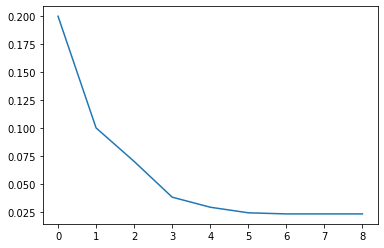

In [9]:
plt.plot(epochs, losses)

Text(0, 0.5, 'loss')

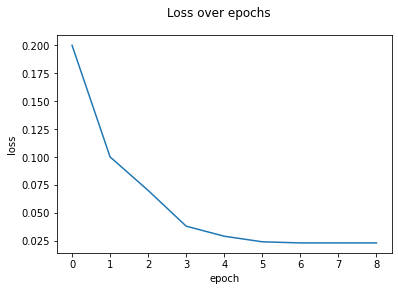

In [14]:
fig = plt.figure()
plt.plot(epochs, losses)
fig.suptitle('Loss over epochs')
plt.xlabel('epoch')
plt.ylabel('loss')
#fig.savefig('loss_plot.jpg')

In [18]:
rate = 0.01
path = "sdkjfh" + str(rate) + "fsdfs"

In [19]:
path

'sdkjfh0.01fsdfs'